In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import grad
import einops

import numpy as np
import matplotlib.pyplot as plt
import copy
import pickle
import os
import glob
from symm_loss_defs import *
from decimal import Decimal

Using cuda device


In [4]:
#filename = "N_10000_hidden_size_100_layers_3_activation_GeLU_lr_0.0001_opt_Adam_data_seed_4810_train_seed_6244"
#filename = "N_10000_hidden_size_100_layers_3_activation_GeLU_lr_0.0001_opt_Adam_data_seed_2602_train_seed_3399"
#filename = "N_100000_hidden_size_300_layers_3_activation_GeLU_lr_0.0001_opt_Adam_data_seed_8981_train_seed_2668"
filename = "N_100000_hidden_size_300_layers_3_activation_GeLU_lr_1e-05_opt_Adam_data_seed_5927_train_seed_3643"
with open(f"./storage/{filename}.pkl","rb") as f:
    a = pickle.load(f)

In [3]:
def Lorentz_myfun(input):
        m2 = torch.einsum("... i, ij, ...j -> ...",input, torch.diag(torch.tensor([1.00,-1.00,-1.00,-1.00])).to(devicef), input)
        out = m2**2+15*m2
        return out.unsqueeze(1).to(devicef)

In [4]:
def Lorentz_myfun_broken(input,spurions = [torch.tensor([0,0,0,0])]):
    metric_tensor = torch.diag(torch.tensor([1.00,-1.00,-1.00,-1.00])).to(devicef)
    m2 = torch.einsum("... i, ij, ...j -> ...",input, metric_tensor, input)
    breaking_scalars = [torch.einsum("... i, ij, ...j -> ...",spurion.to(devicef), metric_tensor, input) for spurion in spurions]
    coeffs = [20.9983, -23.2444, 3.0459, 12.7176, -17.4378, 1.4378, 10.1877,15.8890, -11.5178,  -4.3926]
    coeffs_2 = [-0.8431,   5.7529,  19.0048,   3.2927, -14.9460,   5.6997,  -5.9202, -10.5052, 2.6883, 16.5809]
    symm_out = m2**2+15*m2
    out = symm_out
    for i in range(len(breaking_scalars)):
        out += coeffs[i%len(coeffs)]*breaking_scalars[i]+coeffs_2[i%len(coeffs_2)]*breaking_scalars[i]**2
    return out.unsqueeze(1).to(devicef)

In [5]:
 def pred_plot_ext(analysis,data,model = "last",transformed_spurions = "True",save = False, outdir = "./",filename = ""):
        inputs = analysis.train_data.to(devicef)
        plt.clf()
        fig = {}
        if model == "last":
            models = analysis.models
            ext = ""
        elif model== "symm":
            models = analysis.models_best_symm
            ext = "_best_symm"
        elif model == "MSE":
            models = analysis.models_best_MSE
            ext = "_best_MSE"
        elif model == "tot":
            models = analysis.models_best_tot
            ext = "_best_tot"
            
        
        
        if analysis.input_spurions == "True" or analysis.input_spurions==True:
            
            lens_spurions = [torch.numel(sp) for sp in analysis.spurions]
            len_spurions = sum(lens_spurions)
            
            truth_data = data[:,0:-len_spurions]
            
            
            if (transformed_spurions == "True" or transformed_spurions == True):
                print(f"now transformed_spurions = {transformed_spurions}")
                d = data.shape[-1]-len_spurions
                sum_length = np.concatenate((np.array([0]),np.cumsum(lens_spurions)))
                trans_spurions = [data[0,(d+sum_length[i]):(d+sum_length[i+1])] for i in range(len(sum_length)-1)]
                print(trans_spurions)
            else:
                trans_spurions = analysis.spurions
                expand_spurions = (torch.cat(trans_spurions)).expand(data.shape[0],len_spurions)
                data = torch.cat((truth_data.to(devicef),expand_spurions.to(devicef)),dim = -1)
        else:
            truth_data = data
            trans_spurions = analysis.spurions
            
            
        if analysis.broken_symm == "True" or analysis.broken_symm == True:
            truth_new = Lorentz_myfun_broken(truth_data,spurions = trans_spurions)
        else:
            truth_new = Lorentz_myfun(truth_data)
            
            
        for lam_val in analysis.models.keys():
            plt.clf()
            fig[lam_val] = plt.figure()
            plt.scatter(analysis.train_labels.cpu().squeeze(),models[lam_val](inputs).detach().cpu().squeeze(),label = rf"$\lambda$ = {lam_val} training data")
            plt.scatter(truth_new.cpu().squeeze(),models[lam_val](data).detach().cpu().squeeze(),label = rf"$\lambda$ = {lam_val} new data",color = "pink",alpha = 0.2)
            plt.scatter(analysis.train_labels.cpu().squeeze(),truth_new.cpu().squeeze(),label = rf"$\lambda$ = {lam_val} new data vs old labels",color = "purple",alpha = 0.05)

            plt.plot(truth_new.cpu().squeeze(),truth_new.cpu().squeeze(),color = "black")
            plt.legend()
            plt.xlabel("truth")
            plt.ylabel("pred")
            err = ((truth_new.cpu().squeeze()-models[lam_val](data).detach().cpu().squeeze())**2).mean()
            #err = '%.4E' % Decimal("f{err}")
            err = "{:.4e}".format(err)
            mse = ((analysis.train_labels.cpu().squeeze()-models[lam_val](inputs).detach().cpu().squeeze())**2).mean()#analysis.train_loss_lam[lam_val][-1]
            mse = "{:.4e}".format(mse)
            
            loss_full = SymmLoss(gens_list=gens_Lorentz, model = models[lam_val])
            
            symm = loss_full(inputs)#analysis.symm_loss_lam[lam_val][-1]
            symm = "{:.4e}".format(symm)
            text = f"lam = {lam_val}, var = {err} MSE = {mse}, symm = {symm}"
            
            if analysis.broken_symm == "True" or analysis.broken_symm == True:
                loss_unbroken = SymmLoss(gens_list=gens_Lorentz[[0,1,-1]], model = models[lam_val])
                symm_unbroken  = loss_unbroken(inputs)
                text = f"{text} unbroken symm = {symm_unbroken}"
                
            print(text)
            text = f"var = {err}, MSE = {mse}, symm = {symm}"
            plt.text(-9, -10,text)
            
            if save==True or save=="True":
                if filename =="":
                    file = f"plot_pred{ext}_lam_{lam_val}_{analysis.filename}"
                else:
                    file = filename
                fig[lam_val].show()
                fig[lam_val].savefig(f"{outdir}/plot_pred{ext}_lam_{lam_val}_{file}_{analysis.filename}.pdf")
            plt.show()
                #plt.close(fig[lam_val])


In [6]:
 def performance_plot_ext(analysis,beta_range = torch.linspace(0,1,100),beta_dir = torch.tensor([1.0,0.0,0.0]),theta_range = torch.linspace(0,2*np.pi,100),theta_dir =torch.tensor([0.0,0.0,1.0]),model = "last",transformed_spurions = "True",save = False, outdir = "./plots",filename = "",relative = False):
        
    ######### initialize #################   
    trans_new_data = torch.zeros(len(beta_range))
    rot_data = torch.zeros(len(theta_range))
    data = analysis.train_data.to(devicef)
    inputs = analysis.train_data.to(devicef)
    if analysis.input_spurions == "True" or analysis.input_spurions==True:
        lens_spurions = [torch.numel(sp) for sp in analysis.spurions]
        len_spurions = sum(lens_spurions)
        data = data[:,0:-len_spurions]
        if transformed_spurions == "False" or transformed_spurions == False:
            ext = "_same_frame"
        else:
            ext = "_trans_frame"

    if model == "last":
        models = analysis.models
        ext = ext
    elif model== "symm":
        models = analysis.models_best_symm
        ext = ext+"_best_symm"
    elif model == "MSE":
        models = analysis.models_best_MSE
        ext = ext+"_best_MSE"
    elif model == "tot":
        models = analysis.models_best_tot
        ext = ext+"_best_tot"

    #####################################

    plt.clf()
    fig = plt.figure()
    err = {}
    color_vec = ["violet","blue","green","yellow","orange","red","pink"]
    model_data_trans = []
    truth_new = []

    for i,beta in enumerate(beta_range):
        trans_new_data = Lorentz_Trans(data = data,beta = beta,beta_dir = beta_dir)
        if analysis.input_spurions == "True" or analysis.input_spurions==True:
            if transformed_spurions == "True" or transformed_spurions == True:
                spurions = [Lorentz_Trans(data = spurion.to(devicef), beta = beta, beta_dir = beta_dir.to(devicef)) for spurion in analysis.spurions]
            else:
                spurions = analysis.spurions

            expand_spurions = (torch.cat(spurions)).expand(trans_new_data.shape[0],len_spurions)
            model_data_trans.append(torch.cat((trans_new_data.to(devicef),expand_spurions.to(devicef)),dim = -1))

        if analysis.broken_symm == "True" or analysis.broken_symm == True:
            truth_new.append(Lorentz_myfun_broken(data ,spurions = spurions))
        else:
            truth_new.append(Lorentz_myfun(data))



    for i,lam_val in enumerate(analysis.models.keys()):
        err[lam_val] = torch.zeros_like(beta_range) 
        mse = ((analysis.train_labels.cpu().squeeze()-models[lam_val](inputs).detach().cpu().squeeze())**2).mean()#analysis.train_loss_lam[lam_val][-1]
        mse = "{:.1e}".format(mse)
        loss_full = SymmLoss(gens_list=gens_Lorentz, model = models[lam_val])
        symm = loss_full(inputs)
        symm = "{:.1e}".format(symm)
        label = rf"$\lambda$ = {lam_val}, train MSE = {mse}, symm = {symm}"

        if analysis.broken_symm == "True" or analysis.broken_symm == True:
            loss_unbroken = SymmLoss(gens_list=gens_Lorentz[[0,1,-1]], model = models[lam_val])
            symm_unbroken  = loss_unbroken(inputs)
            symm_unbroken = "{:.1e}".format(symm_unbroken)
            label = f"{label}, unbroken = {symm_unbroken}"
            
        for j,beta in enumerate(beta_range):
            if relative:
                err[lam_val][j] = (((truth_new[j].cpu().squeeze()-models[lam_val](model_data_trans[j]).detach().cpu().squeeze())/truth_new[j].cpu().squeeze())**2).mean()
            else:
                err[lam_val][j] = (((truth_new[j].cpu().squeeze()-models[lam_val](model_data_trans[j]).detach().cpu().squeeze()))**2).mean()

                
#       
        plt.semilogy(beta_range, err[lam_val],label = label, color = color_vec[i])
        
    plt.legend()
    plt.annotate(rf"$\hat\beta = {beta_dir}$",xy=(0.05,0.35),xycoords = "axes fraction")
    plt.xlabel(r"$\beta$")
    if relative:
        plt.ylabel("relative MSE")
    else:
        plt.ylabel("MSE")
    text = analysis.title()
    plt.title(text)
        
    # if analysis.print_spurions == "True" or analysis.print_spurions == True:
    plt.annotate(analysis.spurions_for_print,xy=(0.05,0.4),xycoords = "axes fraction")
           
    if save==True or save=="True":
        if filename =="":
                file = filename
        else:
            file = f"_{filename}_"
        # fig.show()
        fig.savefig(f"{outdir}/performance_beta_{ext}{file}{analysis.filename}.pdf")

    else:
        fig.show()


            
        # for i,theta in enumerate(theta_range):
        #     rot_data[i] = rot(data = analysis.train_data.to(devicef),theta = theta,theta_dir = theta_dir)


In [7]:
 def performance_plot_ext_theta(analysis,theta_range = torch.linspace(0,2*np.pi,100),theta_dir =torch.tensor([0.0,0.0,1.0]),model = "last",transformed_spurions = "True",save = False, outdir = "./plots",filename = "",relative = False):
        
    ######### initialize #################   
    trans_new_data = torch.zeros(len(theta_range))
    rot_data = torch.zeros(len(theta_range))
    data = analysis.train_data.to(devicef)
    inputs = analysis.train_data.to(devicef)
    if analysis.input_spurions == "True" or analysis.input_spurions==True:
        lens_spurions = [torch.numel(sp) for sp in analysis.spurions]
        len_spurions = sum(lens_spurions)
        data = data[:,0:-len_spurions]
        if transformed_spurions == "False" or transformed_spurions == False:
            ext = "_same_frame"
        else:
            ext = "_trans_frame"

    if model == "last":
        models = analysis.models
        ext = ext
    elif model== "symm":
        models = analysis.models_best_symm
        ext = ext+"_best_symm"
    elif model == "MSE":
        models = analysis.models_best_MSE
        ext = ext+"_best_MSE"
    elif model == "tot":
        models = analysis.models_best_tot
        ext = ext+"_best_tot"

    #####################################

    plt.clf()
    fig = plt.figure()
    err = {}
    color_vec = ["violet","blue","green","yellow","orange","red","pink"]
    model_data_trans = []
    truth_new = []

    for i,theta in enumerate(theta_range):
        trans_new_data = rot(data = data,theta = theta,theta_dir = theta_dir)
        if analysis.input_spurions == "True" or analysis.input_spurions==True:
            if transformed_spurions == "True" or transformed_spurions == True:
                spurions = [rot(data = spurion.to(devicef), theta = theta, theta_dir = theta_dir.to(devicef)) for spurion in analysis.spurions]
            else:
                spurions = analysis.spurions

            expand_spurions = (torch.cat(spurions)).expand(trans_new_data.shape[0],len_spurions)
            model_data_trans.append(torch.cat((trans_new_data.to(devicef),expand_spurions.to(devicef)),dim = -1))

        if analysis.broken_symm == "True" or analysis.broken_symm == True:
            truth_new.append(Lorentz_myfun_broken(data ,spurions = spurions))
        else:
            truth_new.append(Lorentz_myfun(data))



    for i,lam_val in enumerate(analysis.models.keys()):
        err[lam_val] = torch.zeros_like(theta_range) 
        mse = ((analysis.train_labels.cpu().squeeze()-models[lam_val](inputs).detach().cpu().squeeze())**2).mean()#analysis.train_loss_lam[lam_val][-1]
        mse = "{:.1e}".format(mse)
        loss_full = SymmLoss(gens_list=gens_Lorentz, model = models[lam_val])
        symm = loss_full(inputs)
        symm = "{:.1e}".format(symm)
        label = rf"$\lambda$ = {lam_val}, train MSE = {mse}, symm = {symm}"

        if analysis.broken_symm == "True" or analysis.broken_symm == True:
            loss_unbroken = SymmLoss(gens_list=gens_Lorentz[[0,1,-1]], model = models[lam_val])
            symm_unbroken  = loss_unbroken(inputs)
            symm_unbroken = "{:.1e}".format(symm_unbroken)
            label = f"{label}, unbroken = {symm_unbroken}"
            
        for j,theta in enumerate(theta_range):
            if relative:
                err[lam_val][j] = (((truth_new[j].cpu().squeeze()-models[lam_val](model_data_trans[j]).detach().cpu().squeeze())/truth_new[j].cpu().squeeze())**2).mean()
            else:
                err[lam_val][j] = (((truth_new[j].cpu().squeeze()-models[lam_val](model_data_trans[j]).detach().cpu().squeeze()))**2).mean()

                
#       
        plt.semilogy(theta_range, err[lam_val],label = label, color = color_vec[i])
        
    plt.legend()
    plt.annotate(rf"$\hat\theta = {theta_dir}$",xy=(0.05,0.35),xycoords = "axes fraction")
    plt.xlabel(r"$\theta$")
    if relative:
        plt.ylabel("relative MSE")
    else:
        plt.ylabel("MSE")
    text = analysis.title()
    plt.title(text)
        
    # if analysis.print_spurions == "True" or analysis.print_spurions == True:
    plt.annotate(analysis.spurions_for_print,xy=(0.05,0.4),xycoords = "axes fraction")
           
    if save==True or save=="True":
        if filename =="":
                file = filename
        else:
            file = f"_{filename}_"
        # fig.show()
        fig.savefig(f"{outdir}/performance_theta_{ext}{file}{analysis.filename}.pdf")

    else:
        fig.show()


            
        # for i,theta in enumerate(theta_range):
        #     rot_data[i] = rot(data = analysis.train_data.to(devicef),theta = theta,theta_dir = theta_dir)


<Figure size 640x480 with 0 Axes>

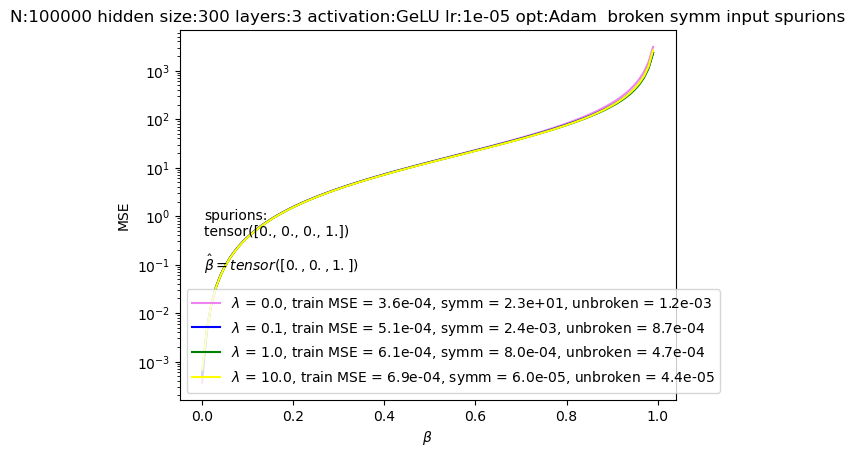

In [66]:
performance_plot_ext(a,save=True,filename="z",beta_dir = torch.tensor([0.0,0.0,1.0]),transformed_spurions = "False")

In [8]:
def analyze(filename, model= "MSE",theta = 0.5,theta_dir = torch.tensor([0,0,1]),beta = 0.6,beta_dir = torch.tensor([1,0,0]),transformed_spurions = "True"):
    with open(f"./storage/{filename}.pkl","rb") as f:
        a = pickle.load(f)
    a.plot_losses()
    if transformed_spurions == "False" or transformed_spurions == False:
        ext = "_same_frame"
    else:
        ext = "_trans_frame"
        
    trans_new_data = Lorentz_Trans(data = a.train_data.to(devicef),beta = beta,beta_dir = beta_dir)
    rot_data = rot(data = a.train_data.to(devicef),theta = theta,theta_dir = theta_dir)
    
    pred_plot_ext(a,rot_data,model = model, save = True, outdir = "./plots",filename = f"rot_{theta}{ext}",transformed_spurions = transformed_spurions)
    pred_plot_ext(a,trans_new_data,model = model,save = True, outdir = "./plots",filename = f"boost_{beta}{ext}",transformed_spurions = transformed_spurions)
    return a


In [9]:
def Lorentz_Trans(data,beta,beta_dir = torch.tensor([1,0,0])):
    gamma = 1/np.sqrt(1-beta**2)
    beta_dir = beta_dir/(torch.sqrt(torch.sum(beta_dir**2)))
    # LorentzBoost = torch.tensor([[gamma, -gamma*beta,  0, 0],[-gamma*beta, gamma, 0, 0],[0,0,1,0],[0,0,0,1]],dtype = torch.float32).to(devicef)
    LorentzBoost = torch.diag(torch.tensor([gamma,1,1,1],dtype = torch.float32)).to(devicef)
    for i in range(1,4):
        LorentzBoost[0,i] += -gamma*beta*beta_dir[i-1]
        LorentzBoost[i,0] += -gamma*beta*beta_dir[i-1]
        for j in range(1,4):
            LorentzBoost[i,j] += 0.5*(gamma-1)*beta_dir[i-1]*beta_dir[j-1]
            LorentzBoost[j,i] += 0.5*(gamma-1)*beta_dir[i-1]*beta_dir[j-1]
    d = 4
    data = einops.rearrange(data, '... (N d) -> ... N d',d = 4)
    trans_data = torch.einsum("ij,...j-> ...i",LorentzBoost,data).to(devicef)
    trans_data = einops.rearrange(trans_data, '... N d -> ... (N d)', d = 4)
    # print(LorentzBoost)
    return trans_data

In [10]:
def rot(data,theta,theta_dir = torch.tensor([0,0,1])):
    theta_dir = (theta_dir.to(devicef)/(torch.sqrt(torch.sum(theta_dir**2))))
    # rotate = torch.tensor([[1, 0,  0, 0],[0, np.cos(theta), np.sin(theta), 0],[0,-np.sin(theta),np.cos(theta),0],[0,0,0,1]],dtype = torch.float32).to(devicef)
    
    rotate = torch.diag(torch.tensor([1,1,1,1],dtype = torch.float32)).to(devicef)
    L_gens = gens_Lorentz[3::].to(devicef)
    e_L_gens = torch.einsum("i,ijk-> jk",theta_dir,L_gens).to(devicef)
    rotate = rotate+np.sin(theta)*e_L_gens+(1-np.cos(theta))*torch.matmul(e_L_gens,e_L_gens)
    
    data = einops.rearrange(data, '... (N d) -> ... N d',d = 4)
    trans_data = torch.einsum("ij,...j-> ...i",rotate,data).to(devicef)
    trans_data = einops.rearrange(trans_data, '... N d -> ... (N d)', d = 4)
    return trans_data

In [28]:
Nnew = 1000
norm = 1.5
new_data  = (torch.rand(Nnew,4)-0.5)*norm
new_data = new_data.to(devicef)

In [7]:
trans_new_data = Lorentz_Trans(data = a.train_data.to(devicef),beta = 0.6)

NameError: name 'a' is not defined

In [ ]:
rot_data = rot(data = a.train_data.to(devicef),theta = 0.5)

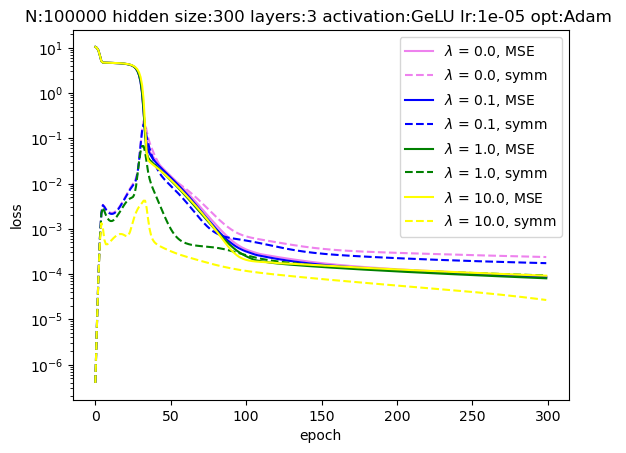

In [23]:
a.plot_losses()

In [24]:
for key in a.train_loss_lam.keys():
    print(f"lam = {key} current MSE loss = {np.min(a.train_loss_lam[key][-1])}")
    print(f"lam = {key} current sym loss = {np.min(a.symm_loss_lam[key][-1])}")
for key in a.train_loss_lam.keys():
    print(f"lam = {key} min MSE loss = {np.min(a.train_loss_lam[key])}")
    print(f"lam = {key} min sym loss = {np.min(a.symm_loss_lam[key])}")


lam = 0.0 current MSE loss = 8.878582753823139e-05
lam = 0.0 current sym loss = 0.0002377936485572718
lam = 0.1 current MSE loss = 8.509340790624264e-05
lam = 0.1 current sym loss = 0.00017425142621505074
lam = 1.0 current MSE loss = 8.057760816882365e-05
lam = 1.0 current sym loss = 9.313061862485483e-05
lam = 10.0 current MSE loss = 9.195333979732822e-05
lam = 10.0 current sym loss = 2.6713794122770197e-05
lam = 0.0 min MSE loss = 8.878582753823139e-05
lam = 0.0 min sym loss = 3.944802807609449e-07
lam = 0.1 min MSE loss = 8.509340790624264e-05
lam = 0.1 min sym loss = 3.944672863553933e-07
lam = 1.0 min MSE loss = 8.057760816882365e-05
lam = 1.0 min sym loss = 3.9435104454810243e-07
lam = 10.0 min MSE loss = 9.195333979732822e-05
lam = 10.0 min sym loss = 3.9318858298997837e-07


N =100,000

lam = 0.0, var = 1.3795e-04 MSE = 8.8786e-05, symm = 2.3779e-04


<Figure size 640x480 with 0 Axes>

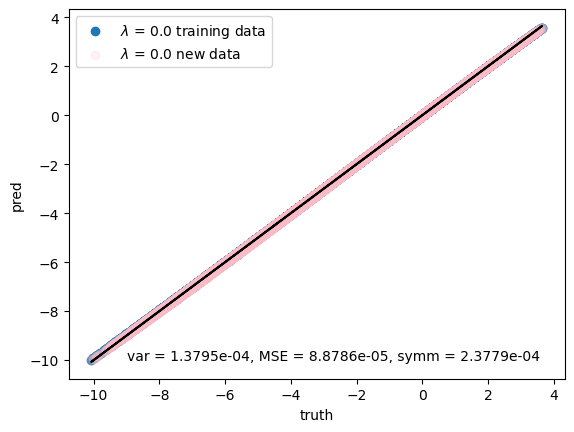

lam = 0.1, var = 1.2720e-04 MSE = 8.5093e-05, symm = 1.7425e-04


<Figure size 640x480 with 0 Axes>

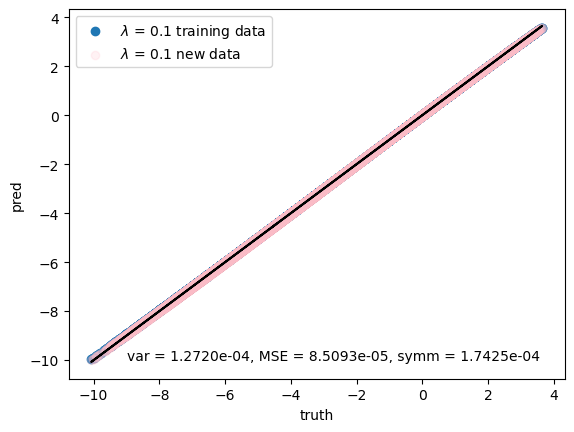

lam = 1.0, var = 8.7832e-05 MSE = 8.0578e-05, symm = 9.3131e-05


<Figure size 640x480 with 0 Axes>

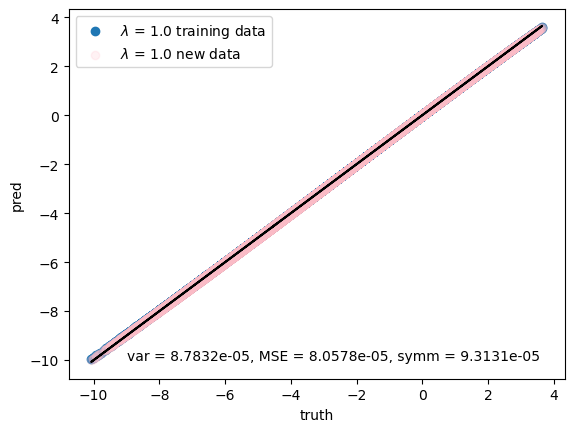

lam = 10.0, var = 8.9994e-05 MSE = 9.1953e-05, symm = 2.6714e-05


<Figure size 640x480 with 0 Axes>

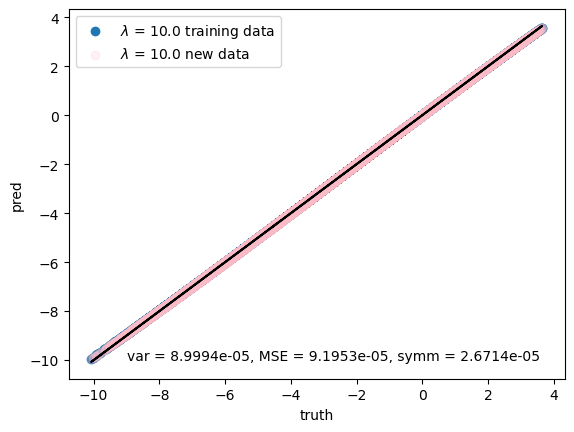

In [67]:
pred_plot_ext(a,rot_data,save = True, outdir = "./plots",filename = f"rot_0.5")

lam = 0.0, var = 1.1673e-02 MSE = 8.8786e-05, symm = 2.3779e-04


<Figure size 640x480 with 0 Axes>

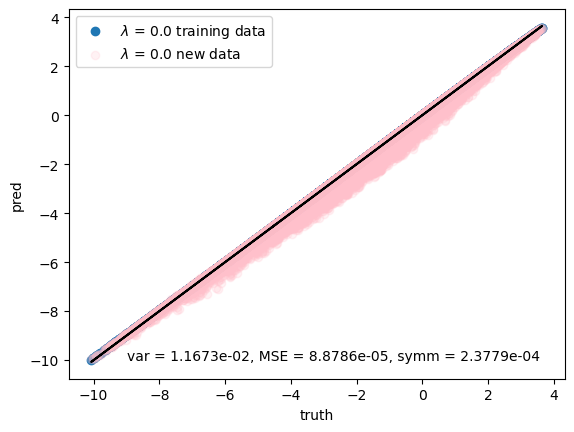

lam = 0.1, var = 6.9460e-03 MSE = 8.5093e-05, symm = 1.7425e-04


<Figure size 640x480 with 0 Axes>

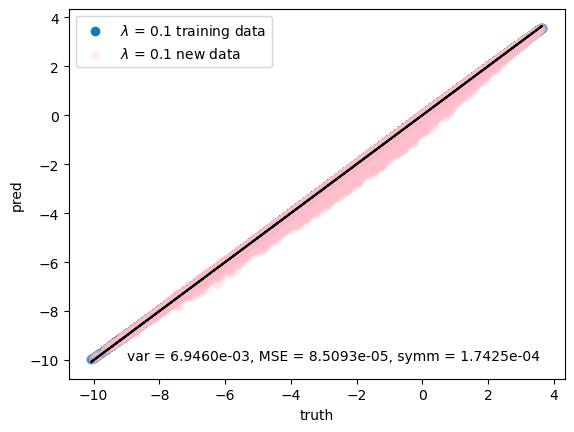

lam = 1.0, var = 2.8520e-03 MSE = 8.0578e-05, symm = 9.3131e-05


<Figure size 640x480 with 0 Axes>

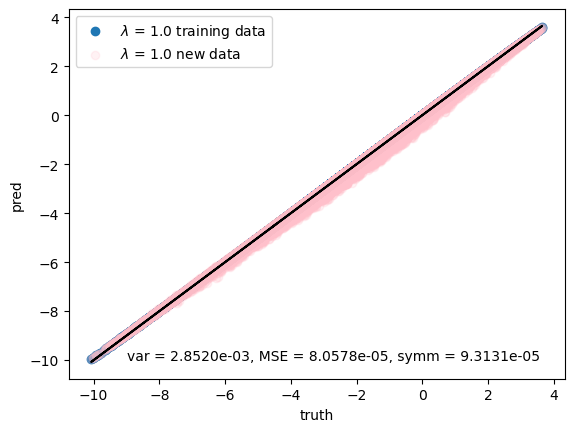

lam = 10.0, var = 1.3649e-03 MSE = 9.1953e-05, symm = 2.6714e-05


<Figure size 640x480 with 0 Axes>

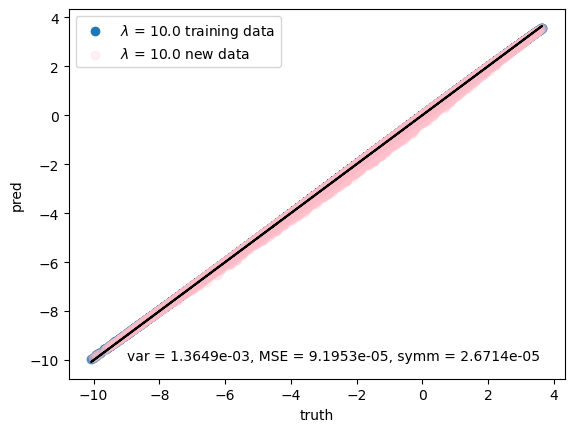

In [68]:
pred_plot_ext(a,trans_new_data,save = True, outdir = "./plots",filename = "boost_0.6")

N = 10,000

lam = 0.0, var = 0.00015094094851519912


<Figure size 640x480 with 0 Axes>

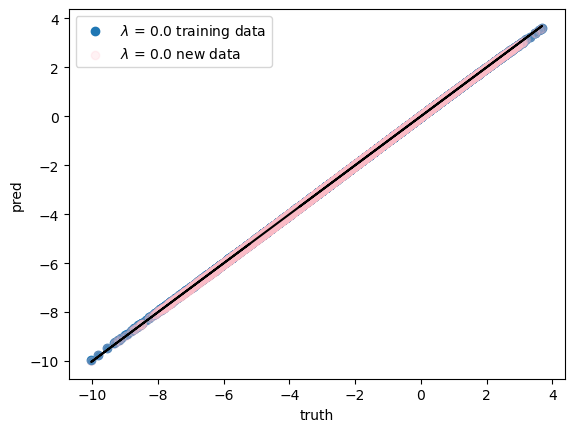

lam = 0.1, var = 0.00013319314166437835


<Figure size 640x480 with 0 Axes>

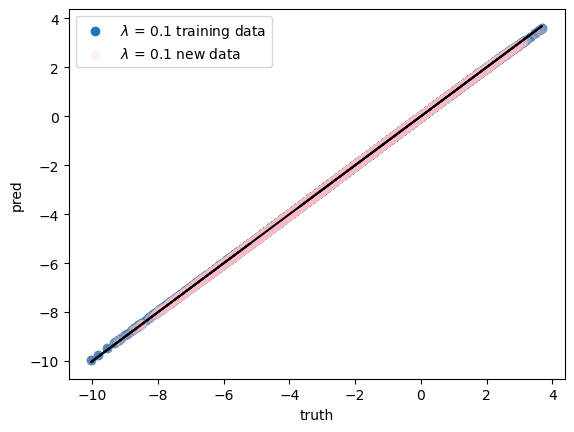

lam = 1.0, var = 0.00013627174485009164


<Figure size 640x480 with 0 Axes>

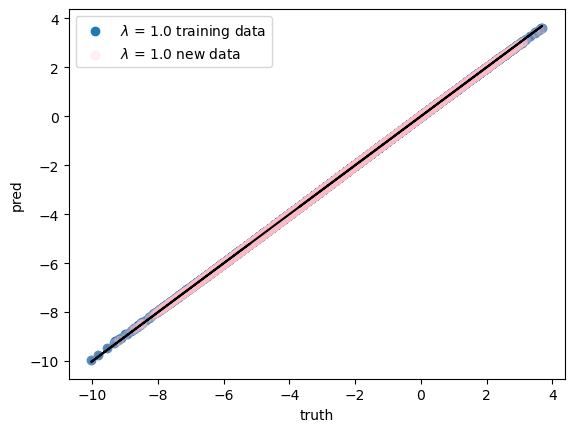

In [14]:
pred_plot_ext(a,rot_data,save = False, outdir = "./",filename = "")

lam = 0.0, var = 0.010359273292124271


<Figure size 640x480 with 0 Axes>

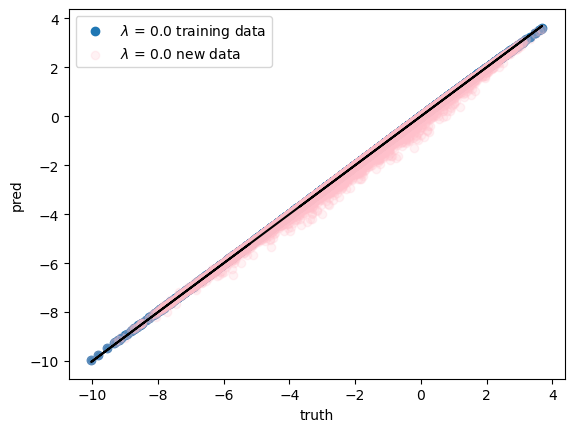

lam = 0.1, var = 0.00585052790120244


<Figure size 640x480 with 0 Axes>

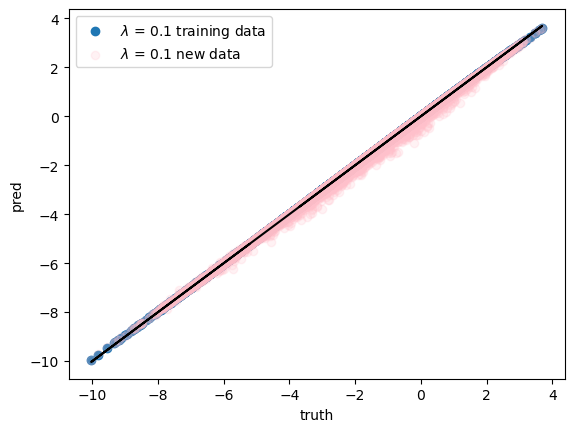

lam = 1.0, var = 0.0021061820443719625


<Figure size 640x480 with 0 Axes>

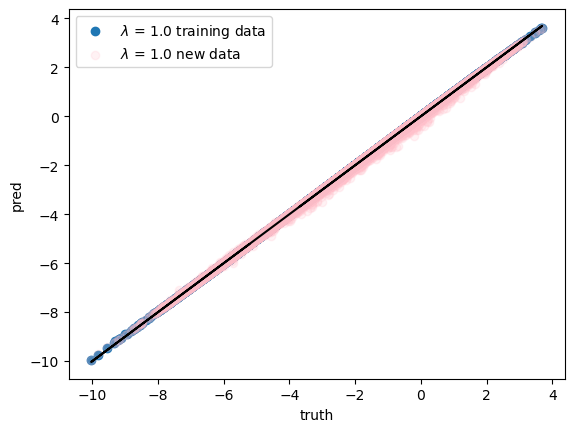

In [19]:
pred_plot_ext(a,trans_new_data,save = False, outdir = "./",filename = "")

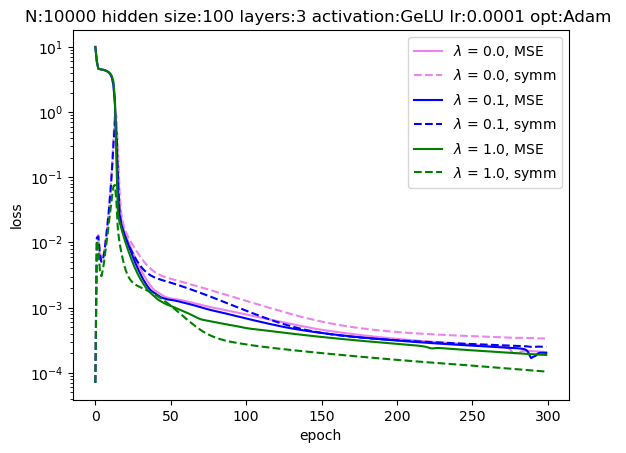

In [20]:
a.plot_losses(save = False, outdir = "./",filename = "")

Bi-linear layer symm loss

In [12]:
filename = "N_100000_hidden_size_300_layers_3_activation_GeLU_lr_5e-05_opt_Adam__bi-linear_layerdata_seed_3458_train_seed_727"
with open(f"./storage/{filename}.pkl","rb") as f:
    a = pickle.load(f)

lam = 0.0, var = 1.3637e-07 MSE = 8.3547e-06, symm = 2.8536e-08


<Figure size 640x480 with 0 Axes>

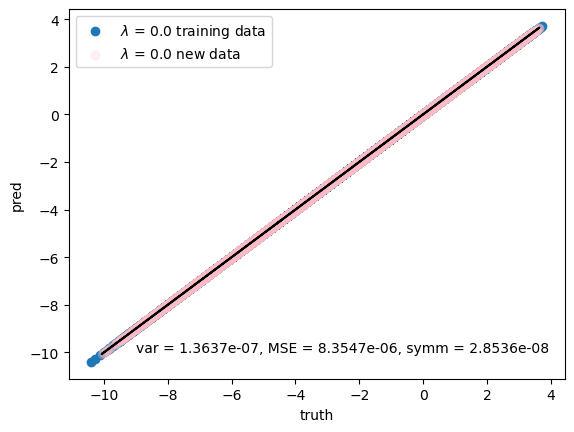

lam = 0.1, var = 1.1419e-06 MSE = 9.0331e-06, symm = 2.2076e-09


<Figure size 640x480 with 0 Axes>

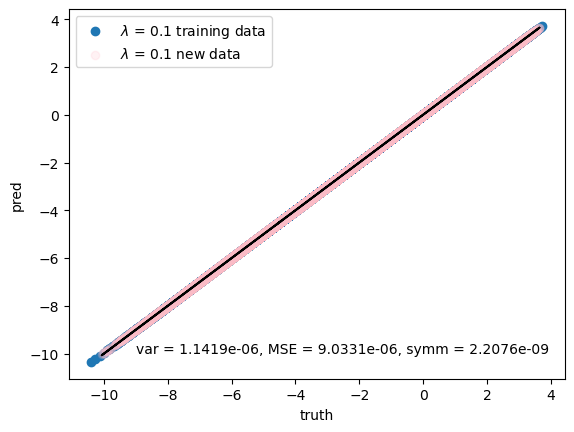

lam = 1.0, var = 5.1279e-06 MSE = 7.9266e-06, symm = 2.7267e-09


<Figure size 640x480 with 0 Axes>

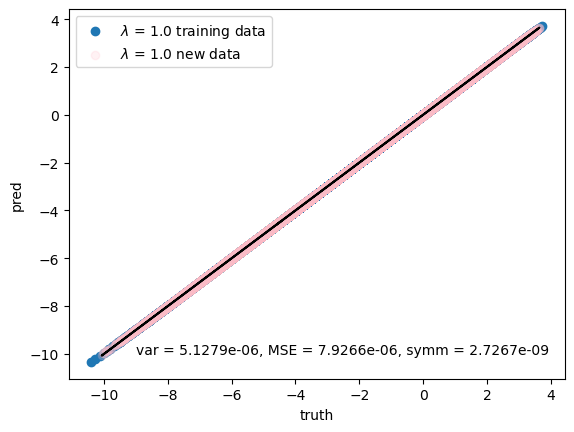

lam = 10.0, var = 8.2862e-06 MSE = 9.4689e-06, symm = 7.7038e-10


<Figure size 640x480 with 0 Axes>

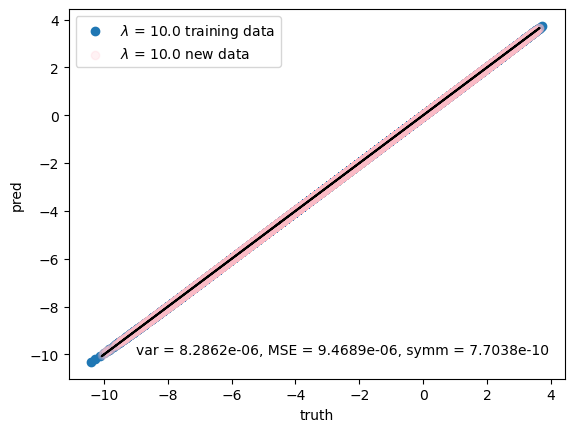

In [14]:
pred_plot_ext(a,rot_data,save = True, outdir = "./plots",filename = f"rot_0.5")

lam = 0.0, var = 1.3467e-07 MSE = 8.3547e-06, symm = 2.8536e-08


<Figure size 640x480 with 0 Axes>

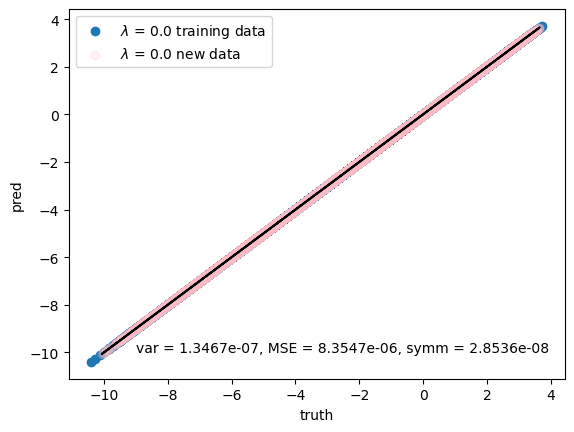

lam = 0.1, var = 1.1288e-06 MSE = 9.0331e-06, symm = 2.2076e-09


<Figure size 640x480 with 0 Axes>

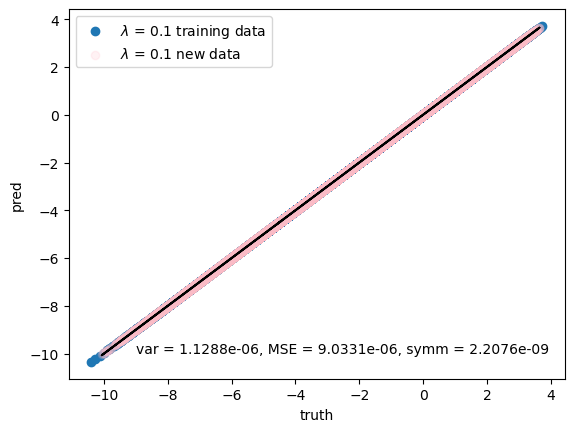

lam = 1.0, var = 5.0549e-06 MSE = 7.9266e-06, symm = 2.7267e-09


<Figure size 640x480 with 0 Axes>

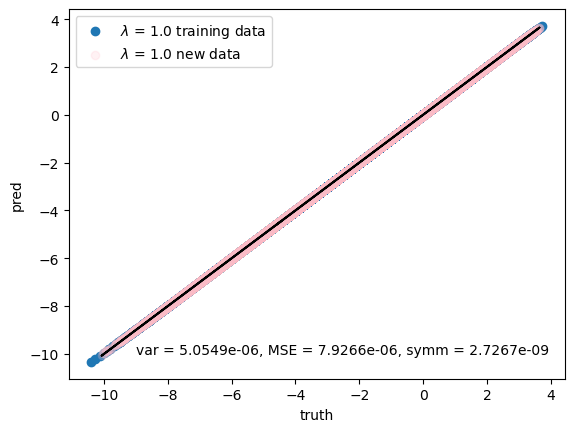

lam = 10.0, var = 8.3456e-06 MSE = 9.4689e-06, symm = 7.7038e-10


<Figure size 640x480 with 0 Axes>

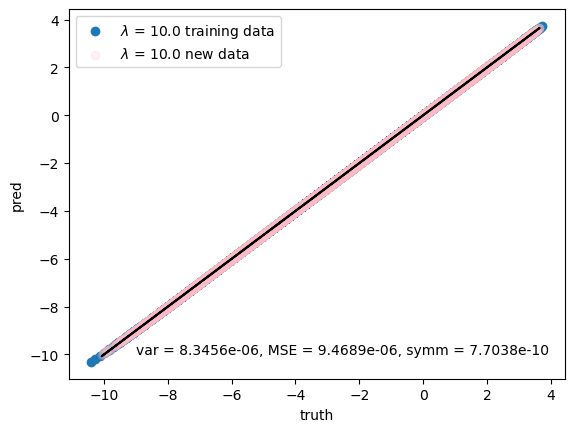

In [15]:
pred_plot_ext(a,trans_new_data,save = True, outdir = "./plots",filename = "boost_0.6")

With normalization

In [43]:
filename = "N_100000_hidden_size_300_layers_3_activation_GeLU_lr_5e-05_opt_Adam__bi-linear_layerdata_seed_3458_train_seed_727"
with open(f"./storage/{filename}.pkl","rb") as f:
    a = pickle.load(f)

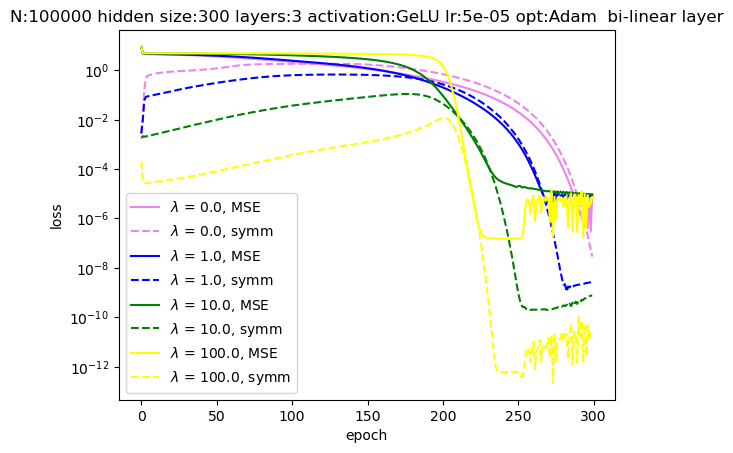

In [9]:
a.plot_losses(save = False, outdir = "./",filename = "")

In [10]:
a.symm_norm

'False'

In [9]:
class SymmLoss_norm_debug(nn.Module):

    def __init__(self, gens_list,model,device = devicef):
        super(SymmLoss_norm_debug, self).__init__()
        
        self.model = model.to(device)
        self.device = device
        # Initialize generators (in future add different reps for inputs?)
        self.generators = einops.rearrange(gens_list, 'n w h -> n w h')
        self.generators = self.generators.to(device)
        

    
    def forward(self, input, model_rep='scalar',norm = "none"):
        
        input = input.clone().detach().requires_grad_(True)
        input = input.to(self.device)
        # Compute model output, shape [B]
        output = self.model(input)

        # Compute gradients with respect to input, shape [B, d*N], B is the batch size, d is the input irrep dimension, N is the number of particles
        grads, = torch.autograd.grad(outputs=output, inputs=input, grad_outputs=torch.ones_like(output, device=self.device), create_graph=True)
        
        grads_norm = torch.einsum('... N, ... N -> ...', grads, grads)
        #print(grads_norm.mean())
        
        # Reshape grads to [B, N, d] 
        grads = einops.rearrange(grads, '... (N d) -> ... N d',d = self.generators.shape[-1])

        # Contract grads with generators, shape [n (generators), B, N, d]
        gen_grads = torch.einsum('n h d, ... N h->  n ... N d ',self.generators, grads)
        # Reshape to [n, B, (d N)]
        gen_grads = einops.rearrange(gen_grads, 'n ... N d -> n ... (N d)')

        # Dot with input [n ,B]
        differential_trans = torch.einsum('n ... N, ... N -> n ...', gen_grads, input)
        
       
        
        # scalar_loss = (differential_trans ** 2).mean()
        # print(f"symm loss = {scalar_loss}")
        
        scalar_loss_norm = (1/len(self.generators))*(torch.sum(differential_trans**2,dim = 0)/grads_norm).mean()
            
        return scalar_loss_norm,grads,grads_norm


In [36]:
filename = "N_100000_hidden_size_300_layers_3_activation_GeLU_lr_5e-05_opt_Adam__bi-linear_layer_normdata_seed_3458_train_seed_727"
with open(f"./storage/{filename}.pkl","rb") as f:
    a = pickle.load(f)

In [37]:
Lorentz_loss_norm = {}
grads = {}
grads_norm = {}
for key in a.models.keys():
    loss = SymmLoss_norm_debug(gens_list=gens_Lorentz, model = a.models[key])
    Lorentz_loss_norm[key],grads[key],grads_norm[key]  = loss(a.train_data)

NameError: name 'SymmLoss_norm_debug' is not defined

In [11]:
for key in grads_norm.keys():
    print(f"lambda = {key}:")
    print(f"min gard^2 = {min(grads_norm[key])}")
    print(f"max gard^2 = {max(grads_norm[key])}")
    print(f"mean grad^2 = {grads_norm[key].mean()}")

lambda = 0.0:
min gard^2 = 0.9617189168930054
max gard^2 = 737.723876953125
mean grad^2 = 283.9656066894531
lambda = 100:
min gard^2 = 0.9615445733070374
max gard^2 = 738.0885009765625
mean grad^2 = 283.9857482910156
lambda = 1000.0:
min gard^2 = 0.9625749588012695
max gard^2 = 738.3421020507812
mean grad^2 = 283.98919677734375
lambda = 10000.0:
min gard^2 = 0.9606664776802063
max gard^2 = 736.69873046875
mean grad^2 = 283.3349914550781
lambda = 100000.0:
min gard^2 = 0.9612112045288086
max gard^2 = 738.4191284179688
mean grad^2 = 284.0018615722656


In [12]:
Lorentz_loss_norm

{0.0: tensor(1.4240e-13, device='cuda:0', grad_fn=<MulBackward0>),
 100: tensor(1.2397e-12, device='cuda:0', grad_fn=<MulBackward0>),
 1000.0: tensor(2.3168e-14, device='cuda:0', grad_fn=<MulBackward0>),
 10000.0: tensor(8.7121e-12, device='cuda:0', grad_fn=<MulBackward0>),
 100000.0: tensor(1.8517e-13, device='cuda:0', grad_fn=<MulBackward0>)}

lam = 0.0, var = 1.7645e-08 MSE = 4.2603e-08, symm = 3.5853e-12


<Figure size 640x480 with 0 Axes>

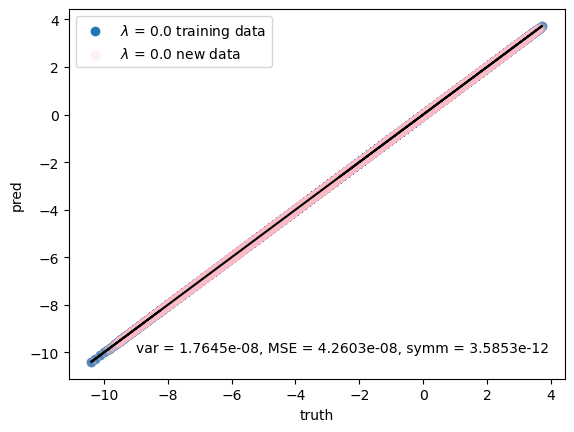

lam = 100, var = 2.1105e-08 MSE = 3.0074e-06, symm = 3.6831e-11


<Figure size 640x480 with 0 Axes>

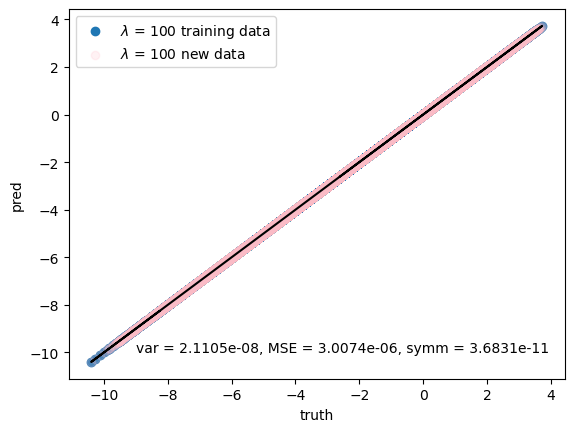

lam = 1000.0, var = 1.9130e-08 MSE = 3.5340e-08, symm = 2.2936e-13


<Figure size 640x480 with 0 Axes>

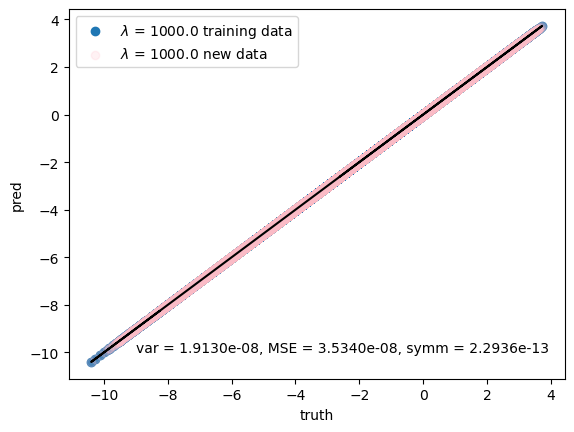

lam = 10000.0, var = 2.3534e-08 MSE = 2.3393e-06, symm = 1.6781e-13


<Figure size 640x480 with 0 Axes>

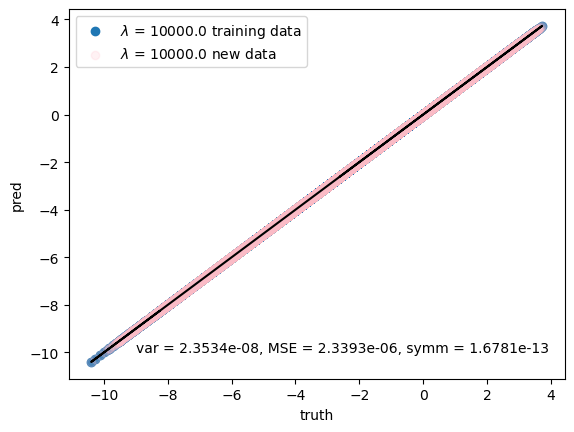

lam = 100000.0, var = 2.1610e-08 MSE = 8.0215e-06, symm = 4.2191e-13


<Figure size 640x480 with 0 Axes>

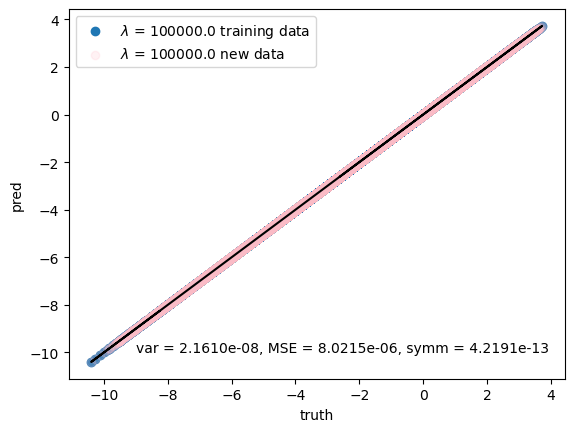

lam = 0.0, var = 1.7450e-08 MSE = 4.2603e-08, symm = 3.5853e-12


<Figure size 640x480 with 0 Axes>

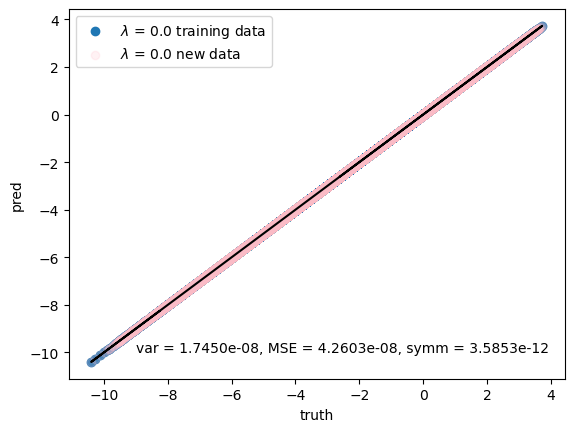

lam = 100, var = 2.1208e-08 MSE = 3.0074e-06, symm = 3.6831e-11


<Figure size 640x480 with 0 Axes>

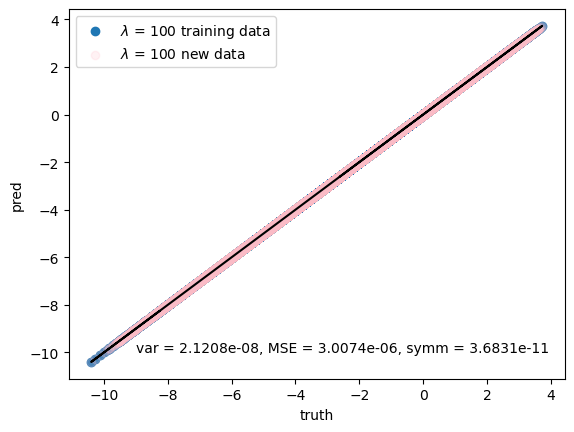

lam = 1000.0, var = 1.9139e-08 MSE = 3.5340e-08, symm = 2.2936e-13


<Figure size 640x480 with 0 Axes>

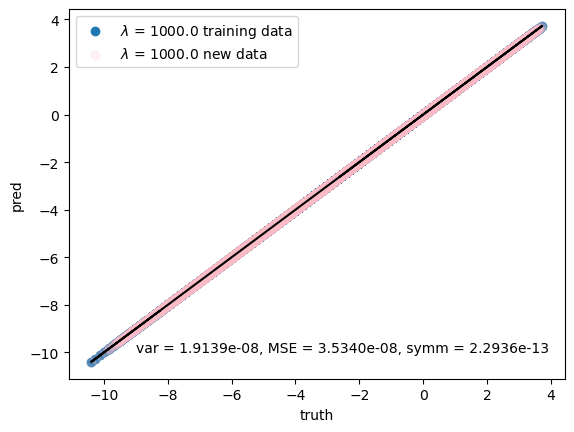

lam = 10000.0, var = 2.3544e-08 MSE = 2.3393e-06, symm = 1.6781e-13


<Figure size 640x480 with 0 Axes>

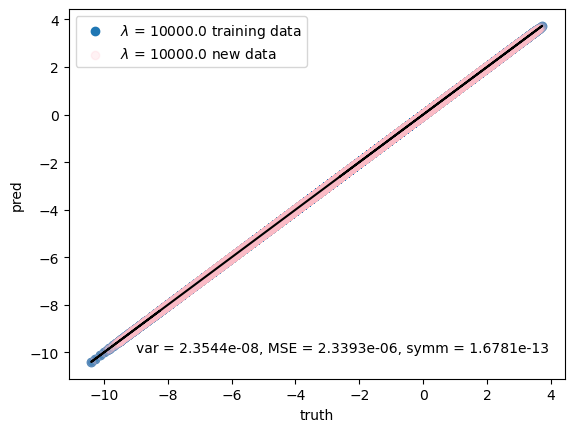

lam = 100000.0, var = 2.1605e-08 MSE = 8.0215e-06, symm = 4.2191e-13


<Figure size 640x480 with 0 Axes>

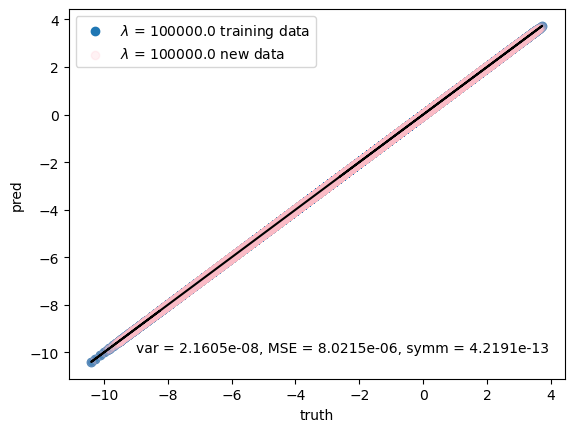

In [20]:
trans_new_data = Lorentz_Trans(data = a.train_data.to(devicef),beta = 0.6)
rot_data = rot(data = a.train_data.to(devicef),theta = 0.5)
pred_plot_ext(a,rot_data,model = "MSE", save = True, outdir = "./plots",filename = f"rot_0.5")
pred_plot_ext(a,trans_new_data,model = "MSE",save = True, outdir = "./plots",filename = "boost_0.6")

Broken

In [38]:
filename = "N_100000_hidden_size_300_layers_3_activation_GeLU_lr_0.0001_opt_Adam__broken_symmdata_seed_177_train_seed_7285"
filename = "N_100000_hidden_size_300_layers_3_activation_GeLU_lr_0.0001_opt_Adam__broken_symmdata_seed_7726_train_seed_2411"
with open(f"./storage/{filename}.pkl","rb") as f:
    a = pickle.load(f)

In [39]:
Lorentz_loss_unbroken = {}
Lorentz_loss = {}

for key in a.models.keys():
    loss = SymmLoss(gens_list=gens_Lorentz[[0,1,-1]], model = a.models[key])
    Lorentz_loss_unbroken[key]  = loss(a.train_data)
    loss_full = SymmLoss(gens_list=gens_Lorentz, model = a.models[key])
    Lorentz_loss[key]  = loss_full(a.train_data)

In [ ]:
a.models[0.0].

In [40]:
for key in Lorentz_loss_unbroken.keys():
    print(f"lambda = {key}:")
    print(f"unbroken symm loss = {Lorentz_loss_unbroken[key]}")
    print(f"full symm loss = {Lorentz_loss[key]}")
    print(f"MSE = {a.train_loss_lam[key][-1]}")

lambda = 0.0:
unbroken symm loss = 0.00026294594863429666
full symm loss = 18.418962478637695
MSE = 0.0003597565872769337
lambda = 1e-07:
unbroken symm loss = 0.00021705846302211285
full symm loss = 18.390287399291992
MSE = 2.538095152885944e-05
lambda = 1e-06:
unbroken symm loss = 0.00020917561778333038
full symm loss = 18.39604377746582
MSE = 5.2571174328477356e-05
lambda = 1e-05:
unbroken symm loss = 0.00021478303824551404
full symm loss = 18.39131736755371
MSE = 7.632989529156475e-05
lambda = 0.001:
unbroken symm loss = 0.00024068992934189737
full symm loss = 18.28239631652832
MSE = 0.0002521405102015706
lambda = 0.01:
unbroken symm loss = 0.003219127655029297
full symm loss = 17.077476501464844
MSE = 0.005480530546046794
lambda = 0.1:
unbroken symm loss = 0.26604151725769043
full symm loss = 13.285989761352539
MSE = 0.16391409277915955


lam = 0.0, var = 2.2414e-05 MSE = 1.9872e-05, symm = 1.8390e+01 unbroken symm = 0.0002737992617767304


<Figure size 640x480 with 0 Axes>

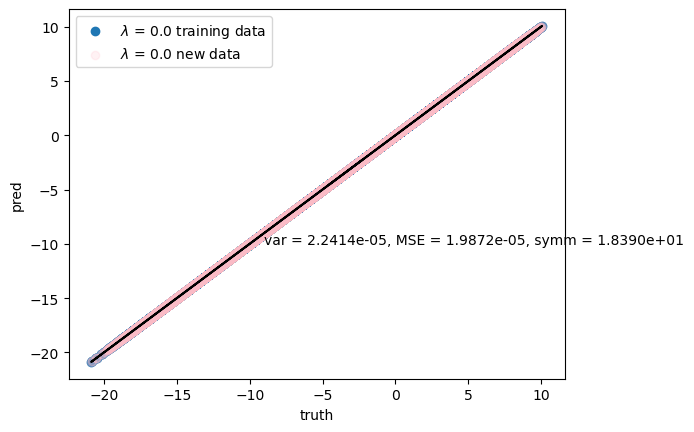

lam = 1e-07, var = 2.2078e-05 MSE = 1.8604e-05, symm = 1.8390e+01 unbroken symm = 0.0002431510220048949


<Figure size 640x480 with 0 Axes>

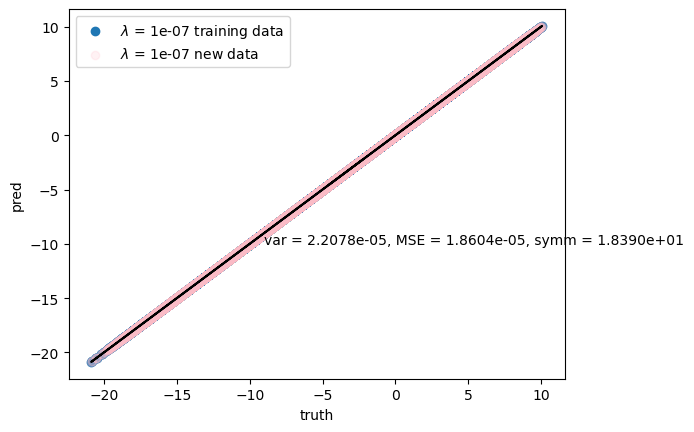

lam = 1e-06, var = 2.0750e-05 MSE = 1.9960e-05, symm = 1.8391e+01 unbroken symm = 0.00023490122111979872


<Figure size 640x480 with 0 Axes>

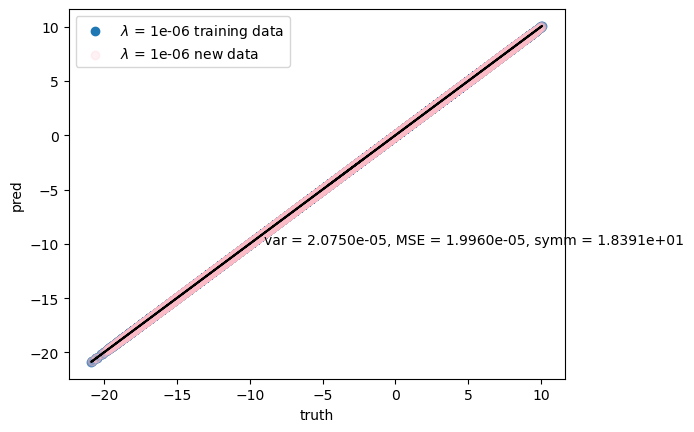

lam = 1e-05, var = 1.9281e-05 MSE = 1.7411e-05, symm = 1.8389e+01 unbroken symm = 0.00023234146647155285


<Figure size 640x480 with 0 Axes>

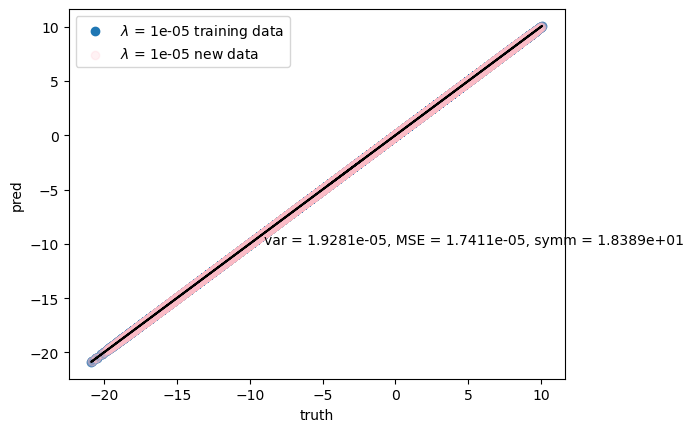

lam = 0.001, var = 1.1831e-04 MSE = 1.2290e-04, symm = 1.8282e+01 unbroken symm = 0.00031669248710386455


<Figure size 640x480 with 0 Axes>

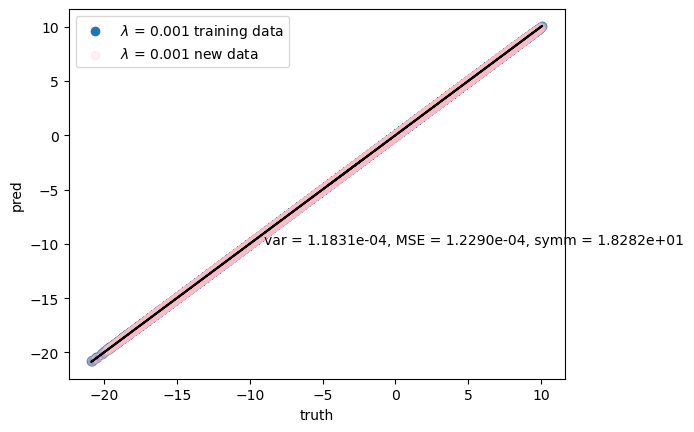

lam = 0.01, var = 5.2825e-03 MSE = 5.2829e-03, symm = 1.7358e+01 unbroken symm = 0.003186828689649701


<Figure size 640x480 with 0 Axes>

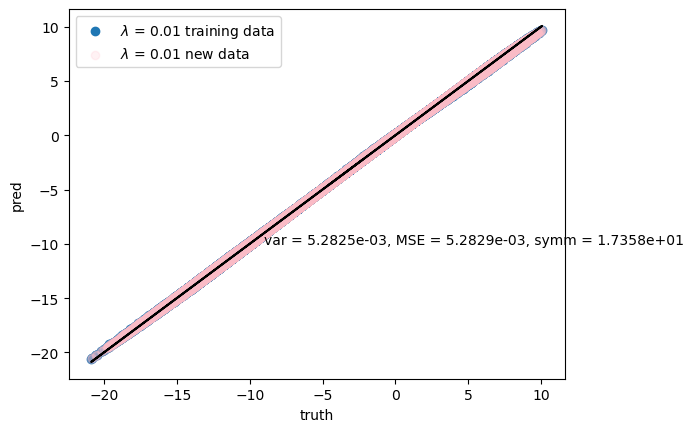

lam = 0.1, var = 1.5586e-01 MSE = 1.5580e-01, symm = 1.4050e+01 unbroken symm = 0.044364020228385925


<Figure size 640x480 with 0 Axes>

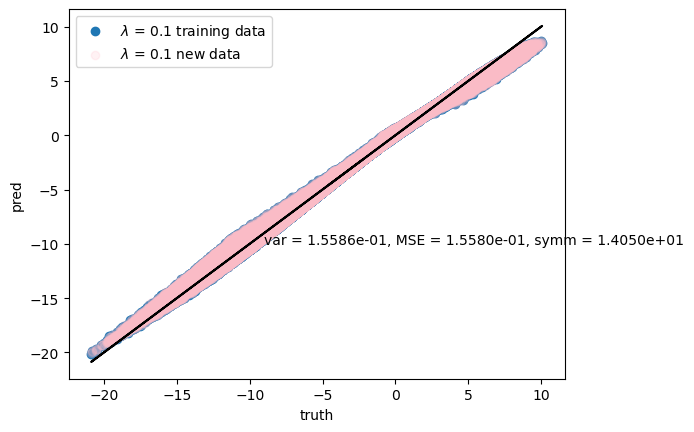

lam = 0.0, var = 7.8869e-03 MSE = 1.9872e-05, symm = 1.8390e+01 unbroken symm = 0.0002737992617767304


<Figure size 640x480 with 0 Axes>

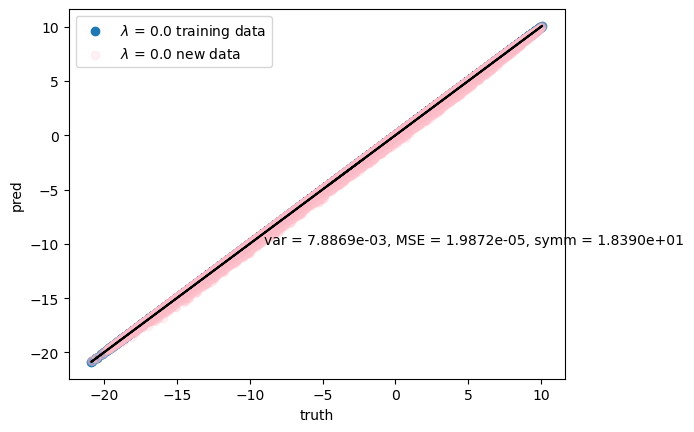

lam = 1e-07, var = 7.3031e-03 MSE = 1.8604e-05, symm = 1.8390e+01 unbroken symm = 0.0002431510220048949


<Figure size 640x480 with 0 Axes>

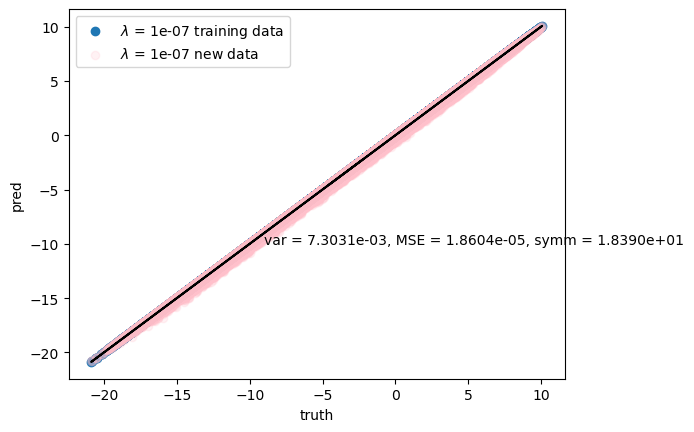

lam = 1e-06, var = 6.9909e-03 MSE = 1.9960e-05, symm = 1.8391e+01 unbroken symm = 0.00023490122111979872


<Figure size 640x480 with 0 Axes>

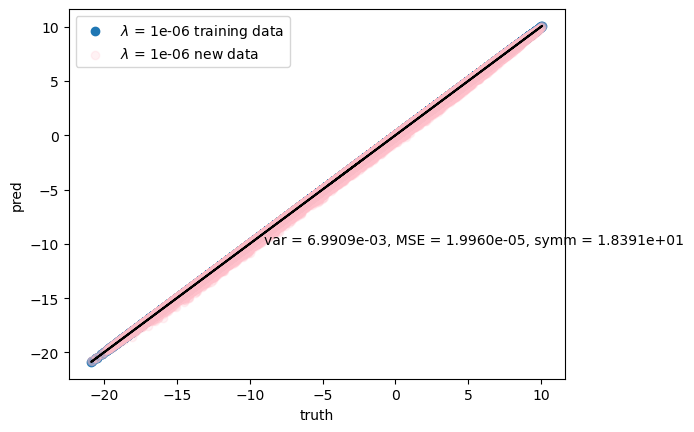

lam = 1e-05, var = 6.9980e-03 MSE = 1.7411e-05, symm = 1.8389e+01 unbroken symm = 0.00023234146647155285


<Figure size 640x480 with 0 Axes>

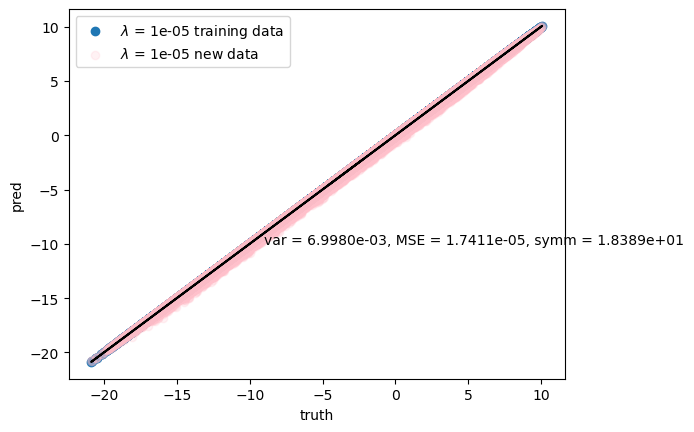

lam = 0.001, var = 7.3017e-03 MSE = 1.2290e-04, symm = 1.8282e+01 unbroken symm = 0.00031669248710386455


<Figure size 640x480 with 0 Axes>

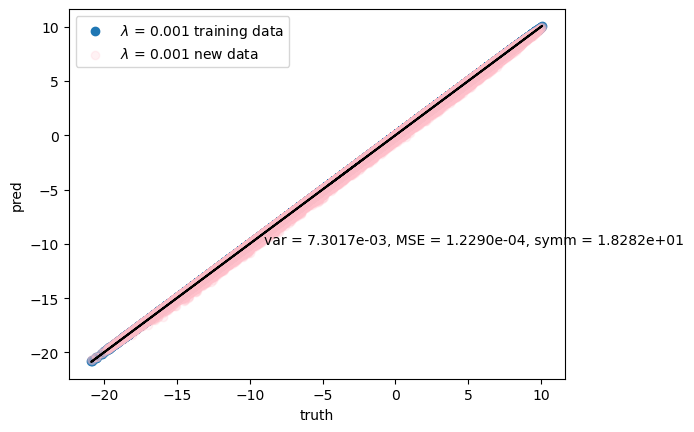

lam = 0.01, var = 2.1130e-02 MSE = 5.2829e-03, symm = 1.7358e+01 unbroken symm = 0.003186828689649701


<Figure size 640x480 with 0 Axes>

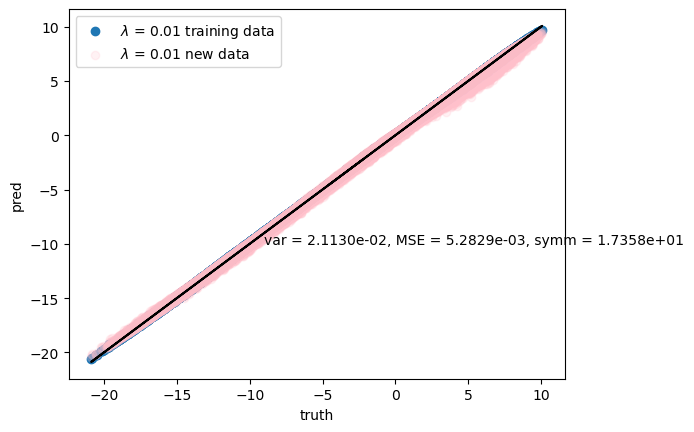

lam = 0.1, var = 2.9152e-01 MSE = 1.5580e-01, symm = 1.4050e+01 unbroken symm = 0.044364020228385925


<Figure size 640x480 with 0 Axes>

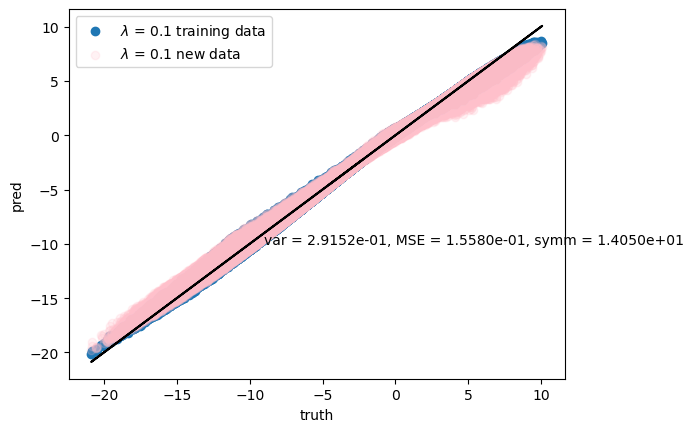

In [52]:
trans_new_data = Lorentz_Trans(data = a.train_data.to(devicef),beta = 0.6)
rot_data = rot(data = a.train_data.to(devicef),theta = 0.5)
pred_plot_ext(a,rot_data,model = "MSE", save = True, outdir = "./plots",filename = f"rot_0.5")
pred_plot_ext(a,trans_new_data,model = "MSE",save = True, outdir = "./plots",filename = "boost_0.6")

Include spurions in input

In [91]:
filename = "N_100000_hidden_size_300_layers_3_activation_GeLU_lr_0.0001_opt_Adam__broken_symmdata_seed_7028_train_seed_4993"
filename = "N_100000_hidden_size_300_layers_3_activation_GeLU_lr_5e-05_opt_Adam__broken_symmdata_seed_7498_train_seed_6249"
with open(f"./storage/{filename}.pkl","rb") as f:
    a = pickle.load(f)


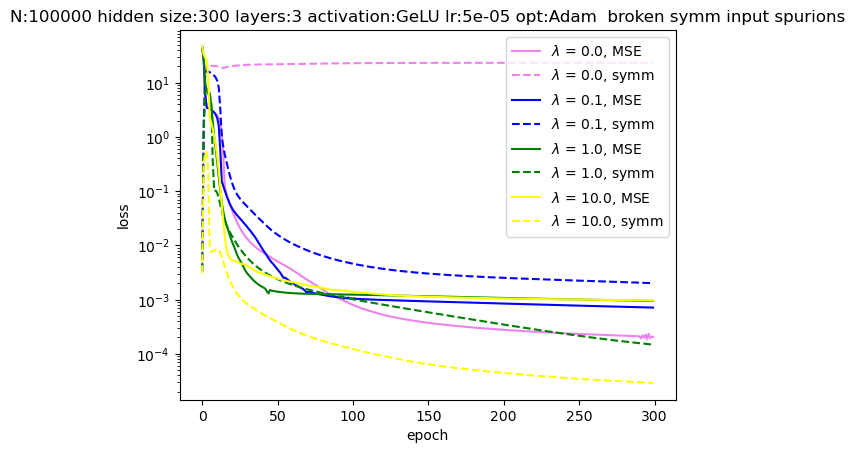

In [93]:
a.plot_losses()

lam = 0.0, var = 3.0796e-04 MSE = 2.4111e-04, symm = 2.3344e+01 unbroken symm = 0.0006381269195117056


<Figure size 640x480 with 0 Axes>

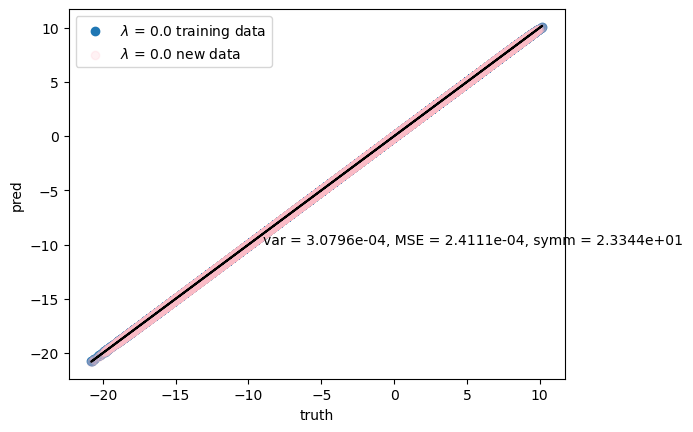

lam = 0.1, var = 8.6816e-04 MSE = 7.6164e-04, symm = 2.0099e-03 unbroken symm = 0.00046075729187577963


<Figure size 640x480 with 0 Axes>

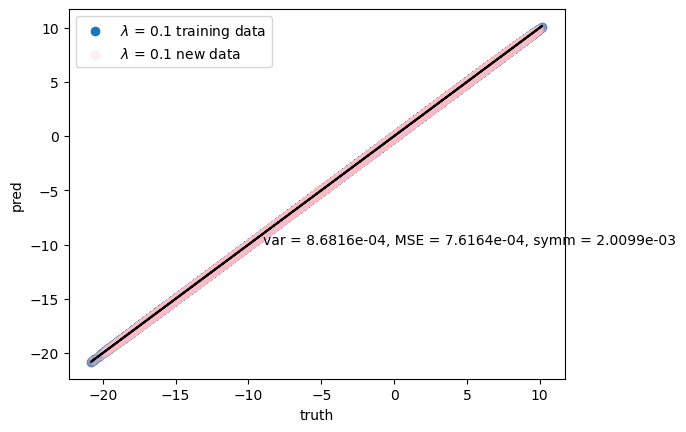

lam = 1.0, var = 6.2361e-04 MSE = 5.5053e-04, symm = 1.5591e-04 unbroken symm = 8.233368134824559e-05


<Figure size 640x480 with 0 Axes>

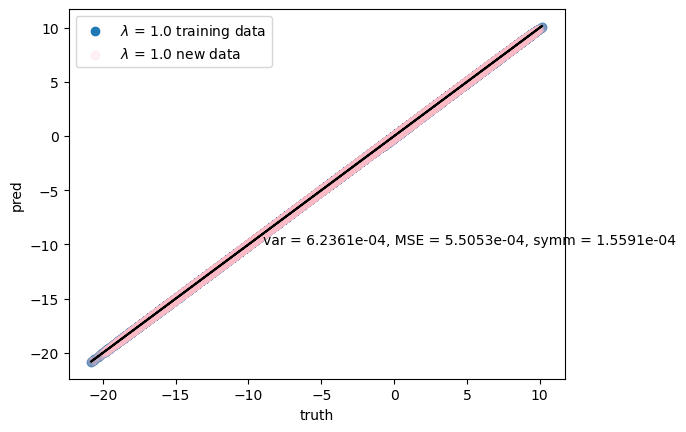

lam = 10.0, var = 4.5326e-04 MSE = 4.3977e-04, symm = 2.0622e-05 unbroken symm = 1.4927596566849388e-05


<Figure size 640x480 with 0 Axes>

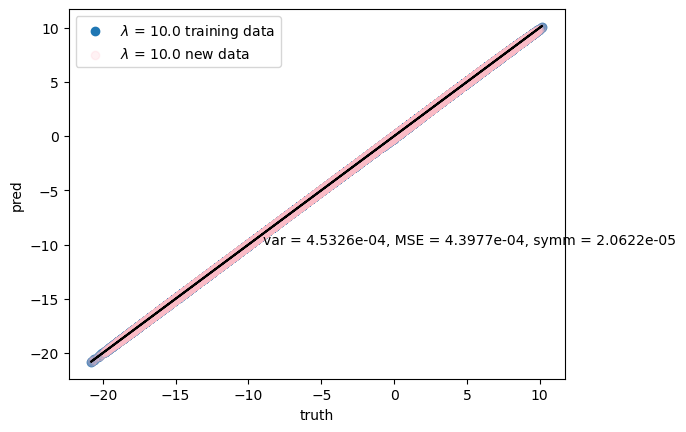

lam = 0.0, var = 1.4261e-02 MSE = 2.4111e-04, symm = 2.3344e+01 unbroken symm = 0.0006381269195117056


<Figure size 640x480 with 0 Axes>

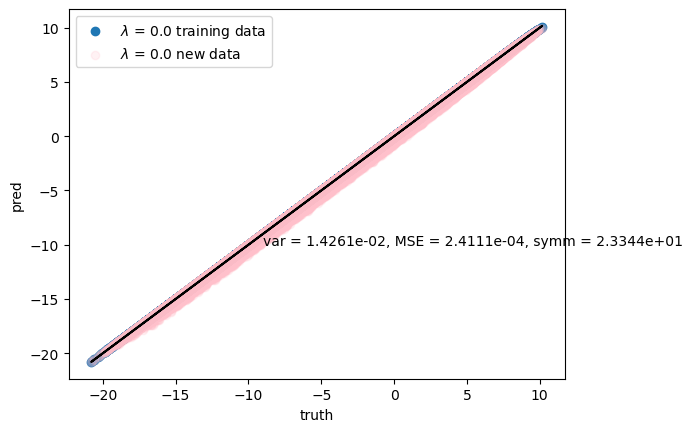

lam = 0.1, var = 6.7057e-03 MSE = 7.6164e-04, symm = 2.0099e-03 unbroken symm = 0.00046075729187577963


<Figure size 640x480 with 0 Axes>

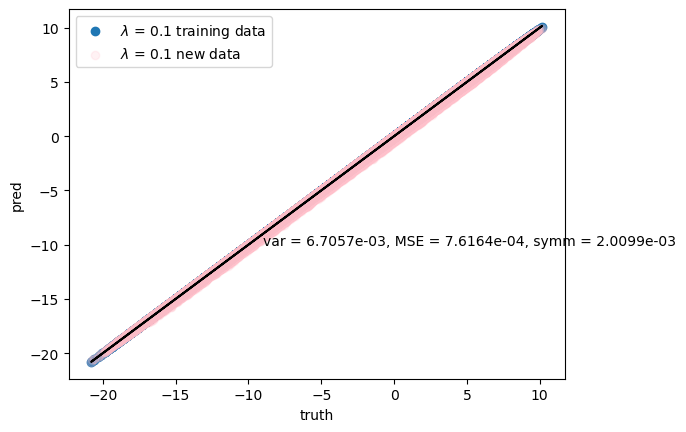

lam = 1.0, var = 2.9096e-03 MSE = 5.5053e-04, symm = 1.5591e-04 unbroken symm = 8.233368134824559e-05


<Figure size 640x480 with 0 Axes>

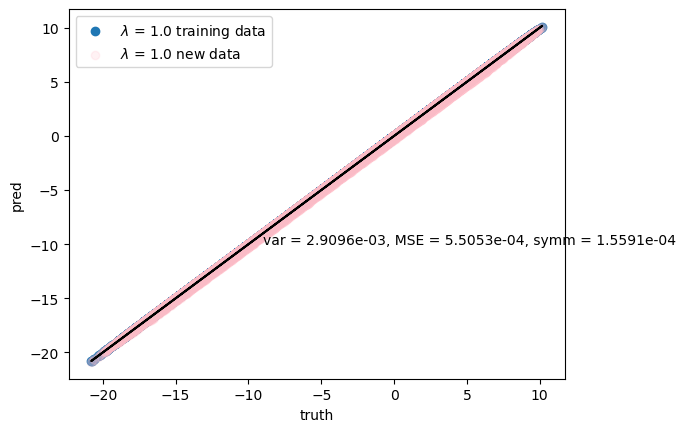

lam = 10.0, var = 6.9606e-04 MSE = 4.3977e-04, symm = 2.0622e-05 unbroken symm = 1.4927596566849388e-05


<Figure size 640x480 with 0 Axes>

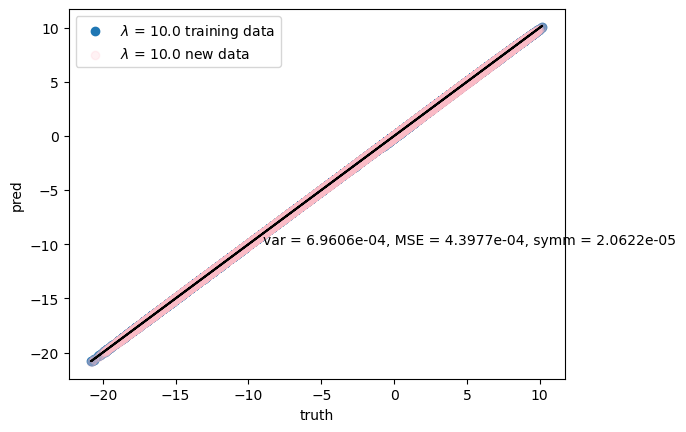

In [102]:
filename = "N_100000_hidden_size_300_layers_3_activation_GeLU_lr_5e-05_opt_Adam__broken_symmdata_seed_7498_train_seed_6249"
a = analyze(filename = filename)

lam = 0.0, var = 1.3684e-04 MSE = 8.6944e-05, symm = 2.3336e+01 unbroken symm = 0.000625853834208101


<Figure size 640x480 with 0 Axes>

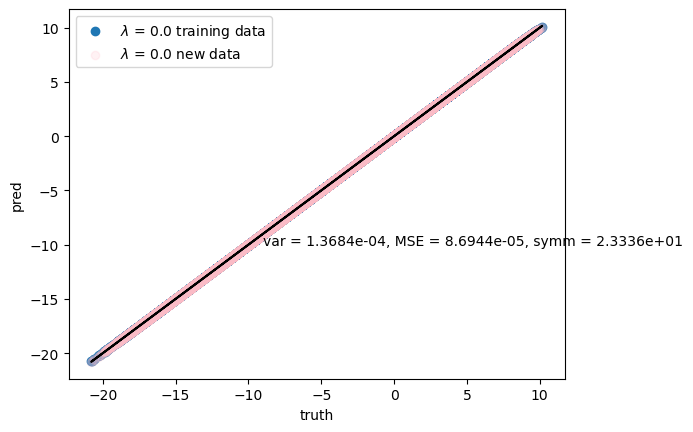

lam = 0.1, var = 8.6816e-04 MSE = 7.6164e-04, symm = 2.0099e-03 unbroken symm = 0.00046075729187577963


<Figure size 640x480 with 0 Axes>

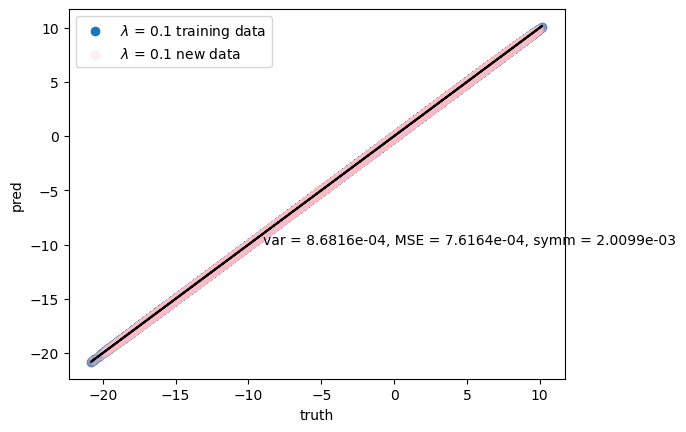

lam = 1.0, var = 6.2361e-04 MSE = 5.5053e-04, symm = 1.5591e-04 unbroken symm = 8.233368134824559e-05


<Figure size 640x480 with 0 Axes>

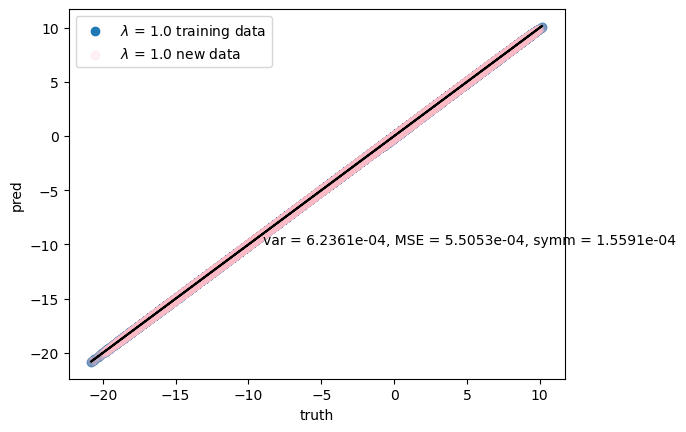

lam = 10.0, var = 4.5326e-04 MSE = 4.3977e-04, symm = 2.0622e-05 unbroken symm = 1.4927596566849388e-05


<Figure size 640x480 with 0 Axes>

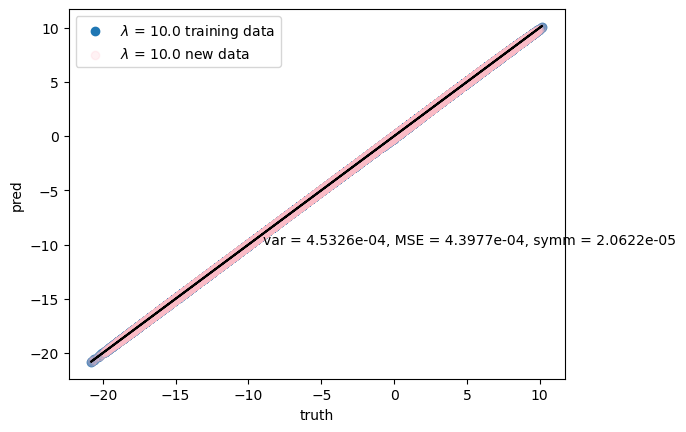

lam = 0.0, var = 1.3260e-02 MSE = 8.6944e-05, symm = 2.3336e+01 unbroken symm = 0.000625853834208101


<Figure size 640x480 with 0 Axes>

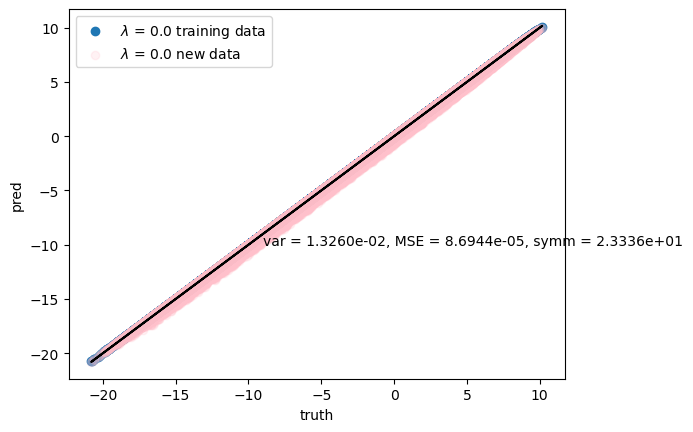

lam = 0.1, var = 6.7057e-03 MSE = 7.6164e-04, symm = 2.0099e-03 unbroken symm = 0.00046075729187577963


<Figure size 640x480 with 0 Axes>

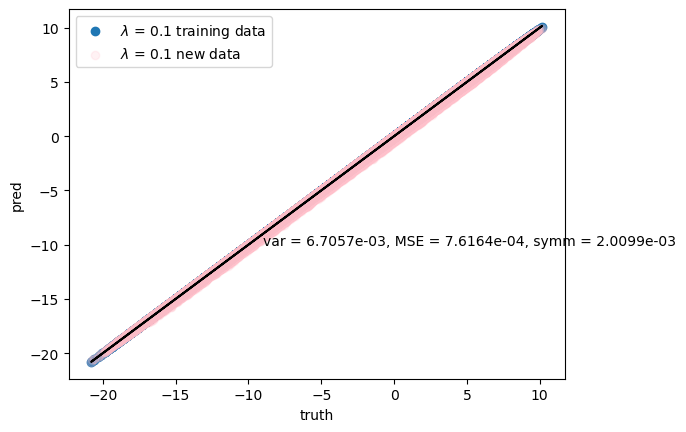

lam = 1.0, var = 2.9096e-03 MSE = 5.5053e-04, symm = 1.5591e-04 unbroken symm = 8.233368134824559e-05


<Figure size 640x480 with 0 Axes>

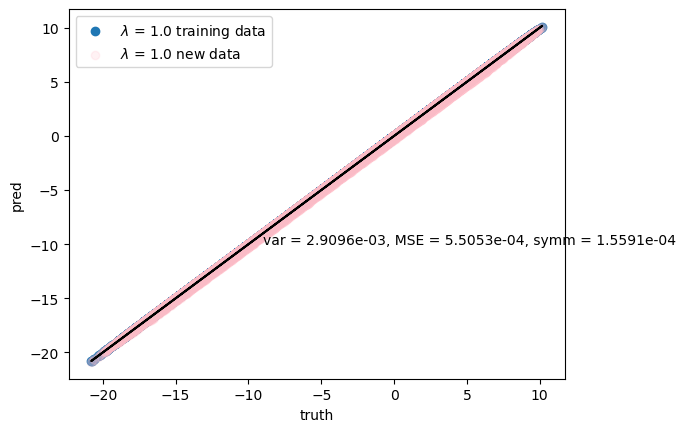

lam = 10.0, var = 6.9606e-04 MSE = 4.3977e-04, symm = 2.0622e-05 unbroken symm = 1.4927596566849388e-05


<Figure size 640x480 with 0 Axes>

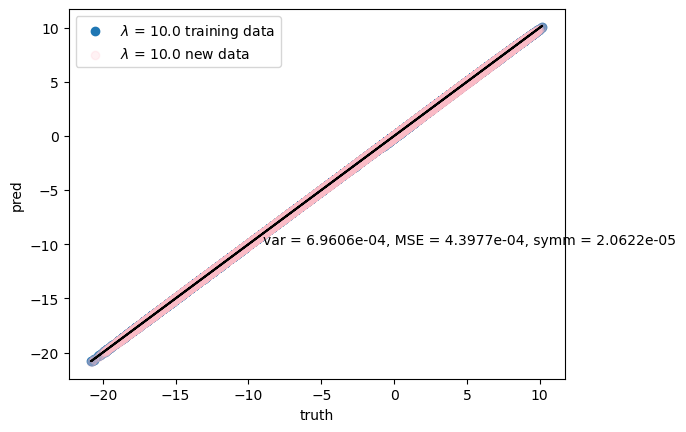

In [103]:
a = analyze(filename, "last")

In [109]:
a = analyze(filename, "last",theta_dir = torch.tensor([1,0,0]),beta_dir = torch.tensor([0,0,1]))

TypeError: only integer scalar arrays can be converted to a scalar index

<Figure size 640x480 with 0 Axes>

lam = 0.0, var = 7.4784e-05 MSE = 6.9335e-05, symm = 2.3354e+01 unbroken symm = 0.00040453975088894367


<Figure size 640x480 with 0 Axes>

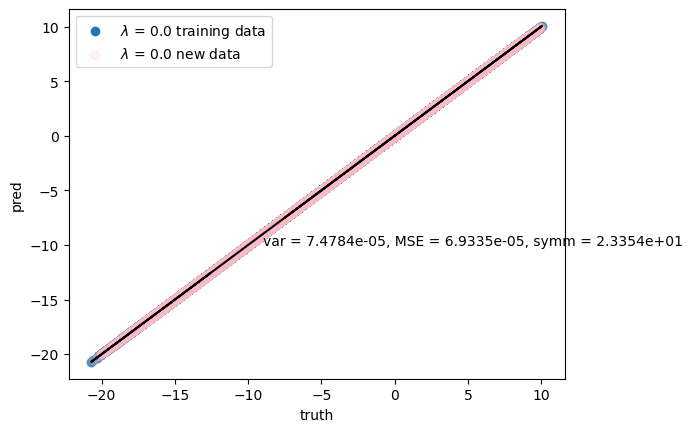

lam = 0.1, var = 8.2039e-04 MSE = 7.6455e-04, symm = 2.0572e-03 unbroken symm = 0.00032729649683460593


<Figure size 640x480 with 0 Axes>

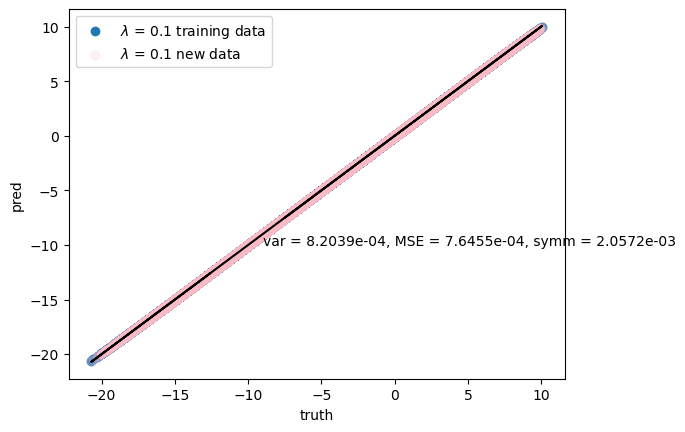

lam = 1.0, var = 1.0622e-03 MSE = 9.8183e-04, symm = 2.3287e-04 unbroken symm = 7.327942876145244e-05


<Figure size 640x480 with 0 Axes>

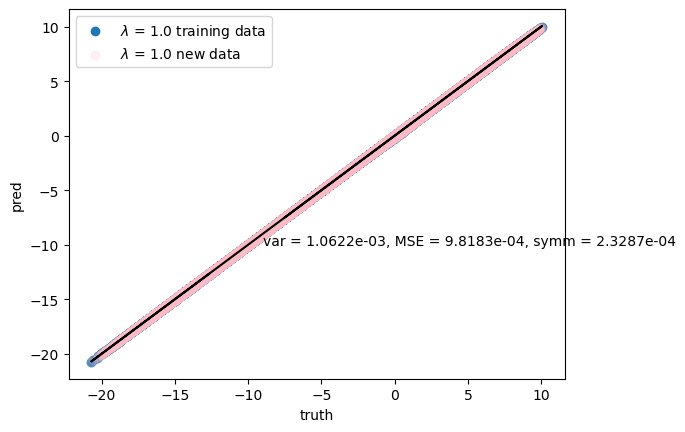

lam = 10.0, var = 9.9458e-04 MSE = 9.4844e-04, symm = 2.1418e-05 unbroken symm = 1.310734933213098e-05


<Figure size 640x480 with 0 Axes>

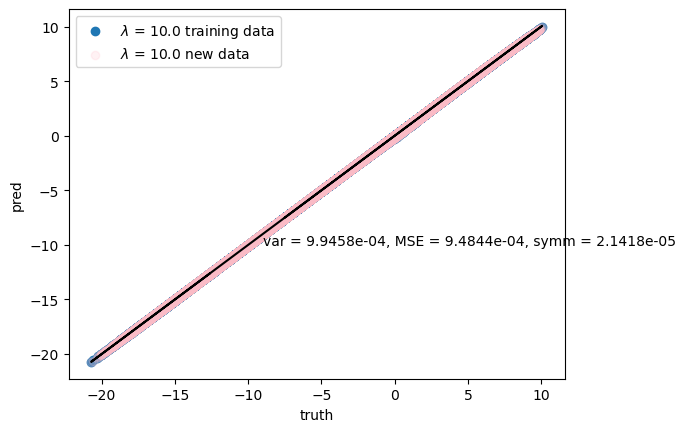

lam = 0.0, var = 5.7092e-03 MSE = 6.9335e-05, symm = 2.3354e+01 unbroken symm = 0.00040453975088894367


<Figure size 640x480 with 0 Axes>

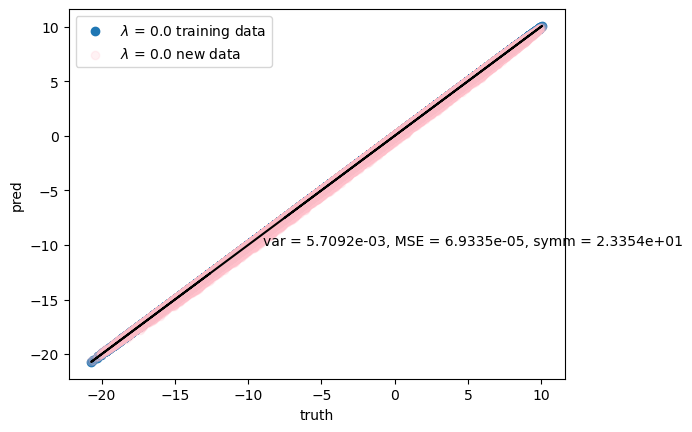

lam = 0.1, var = 4.8025e-03 MSE = 7.6455e-04, symm = 2.0572e-03 unbroken symm = 0.00032729649683460593


<Figure size 640x480 with 0 Axes>

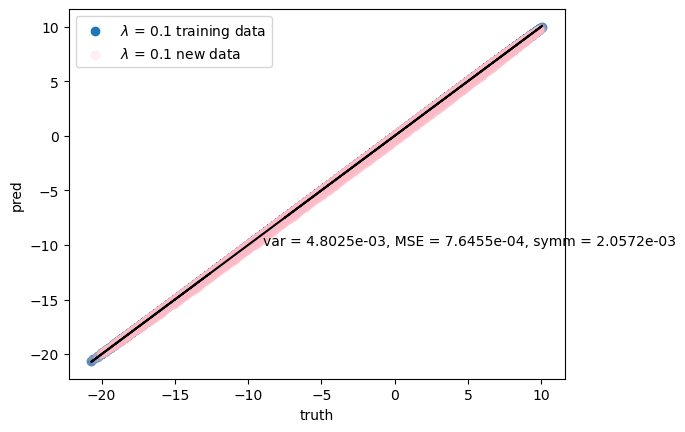

lam = 1.0, var = 3.2482e-03 MSE = 9.8183e-04, symm = 2.3287e-04 unbroken symm = 7.327942876145244e-05


<Figure size 640x480 with 0 Axes>

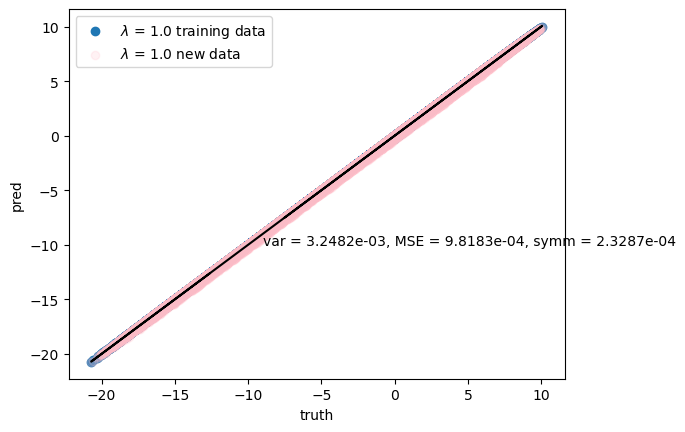

lam = 10.0, var = 1.2162e-03 MSE = 9.4844e-04, symm = 2.1418e-05 unbroken symm = 1.310734933213098e-05


<Figure size 640x480 with 0 Axes>

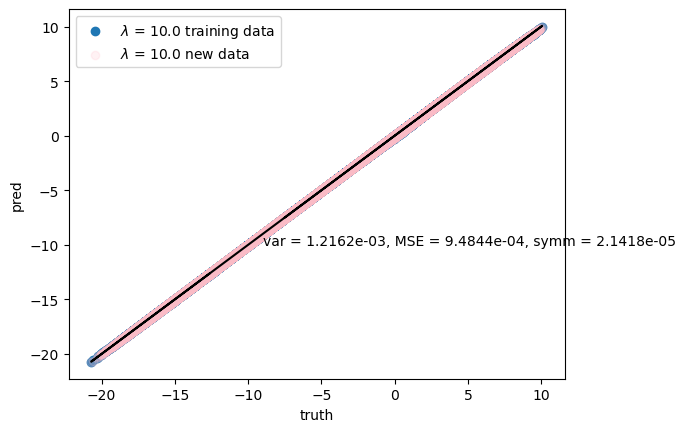

In [117]:
trans_new_data = Lorentz_Trans(data = a.train_data.to(devicef),beta = 0.6)
rot_data = rot(data = a.train_data.to(devicef),theta = 0.5)
pred_plot_ext(a,rot_data,model = "MSE", save = True, outdir = "./plots",filename = f"rot_0.5")
pred_plot_ext(a,trans_new_data,model = "MSE",save = True, outdir = "./plots",filename = "boost_0.6")

lam = 0.0, var = 4.1643e-04 MSE = 3.6232e-04, symm = 2.3411e+01 unbroken symm = 0.001211610739119351


<Figure size 640x480 with 0 Axes>

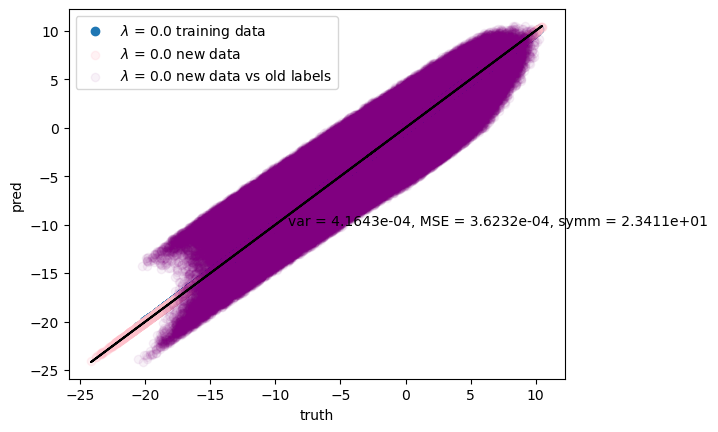

lam = 0.1, var = 5.9504e-04 MSE = 5.0627e-04, symm = 2.4036e-03 unbroken symm = 0.0008724033832550049


<Figure size 640x480 with 0 Axes>

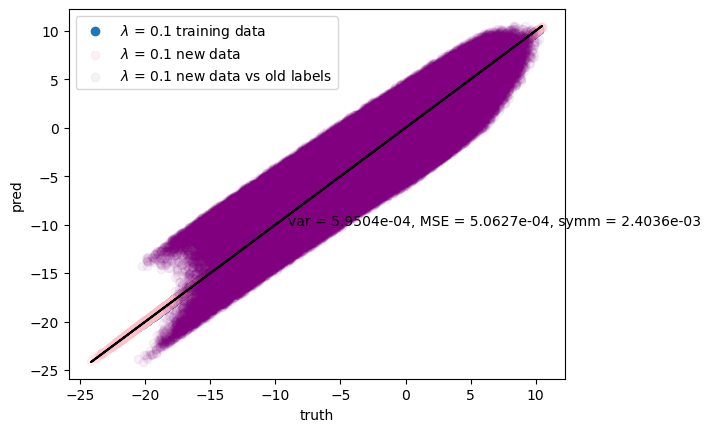

lam = 1.0, var = 7.9591e-04 MSE = 6.1403e-04, symm = 8.0150e-04 unbroken symm = 0.0004716701805591583


<Figure size 640x480 with 0 Axes>

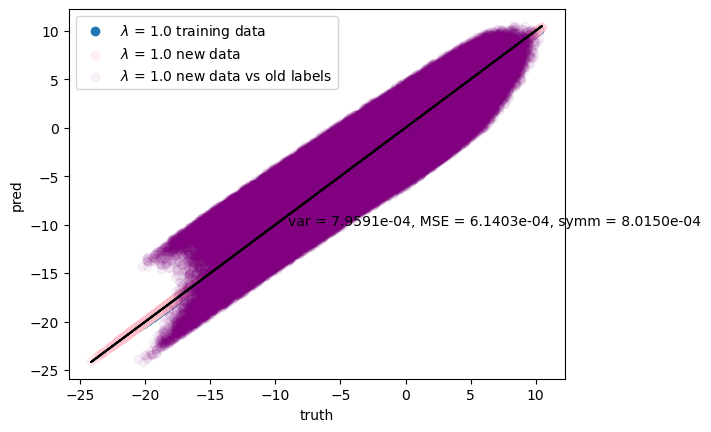

lam = 10.0, var = 1.1777e-03 MSE = 6.8604e-04, symm = 6.0390e-05 unbroken symm = 4.425866427482106e-05


<Figure size 640x480 with 0 Axes>

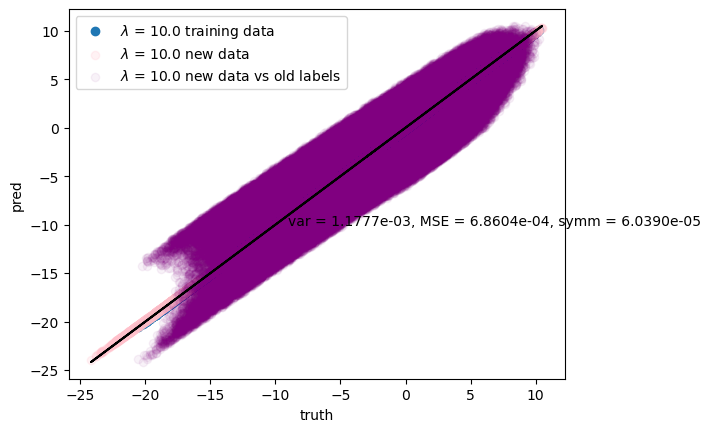

lam = 0.0, var = 2.1335e-03 MSE = 3.6232e-04, symm = 2.3411e+01 unbroken symm = 0.001211610739119351


<Figure size 640x480 with 0 Axes>

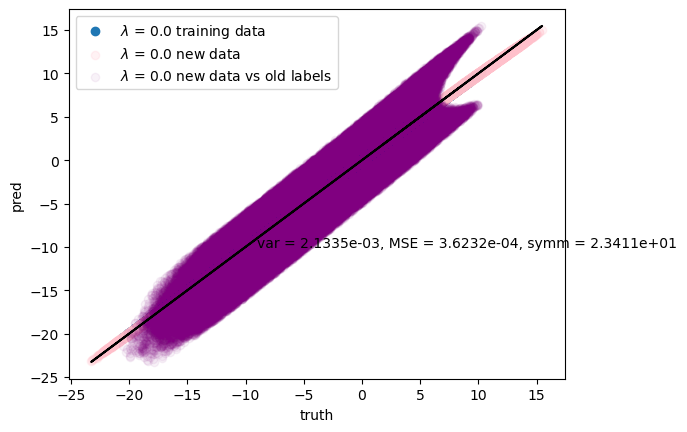

lam = 0.1, var = 2.3605e-03 MSE = 5.0627e-04, symm = 2.4036e-03 unbroken symm = 0.0008724033832550049


<Figure size 640x480 with 0 Axes>

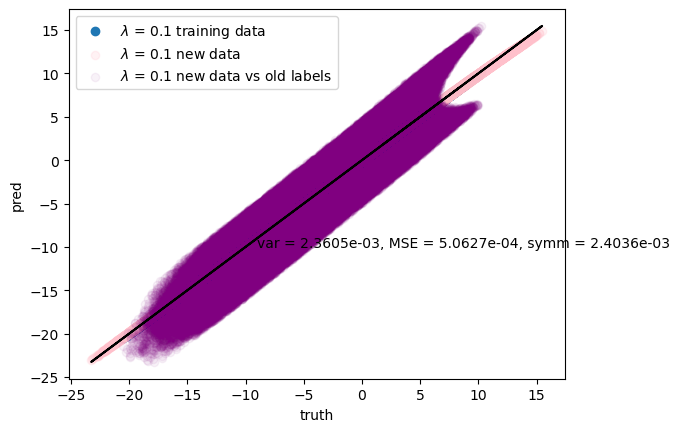

lam = 1.0, var = 2.8067e-03 MSE = 6.1403e-04, symm = 8.0150e-04 unbroken symm = 0.0004716701805591583


<Figure size 640x480 with 0 Axes>

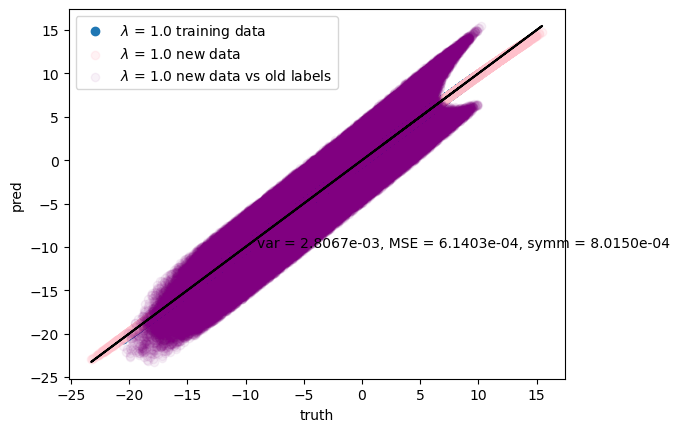

lam = 10.0, var = 4.0253e-03 MSE = 6.8604e-04, symm = 6.0390e-05 unbroken symm = 4.425866427482106e-05


<Figure size 640x480 with 0 Axes>

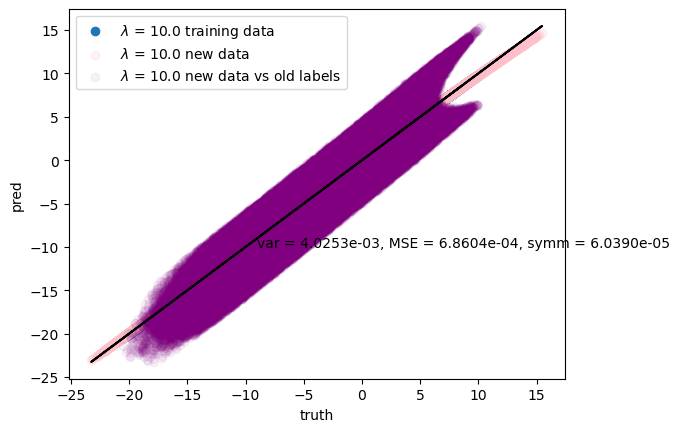

In [67]:
filename = "N_100000_hidden_size_300_layers_3_activation_GeLU_lr_1e-05_opt_Adam__broken_symm_input_spurionsdata_seed_9092_train_seed_8387"
a = analyze(filename, "last",theta_dir = torch.tensor([1,0,0]),beta = 0.4,beta_dir = torch.tensor([0,0,1]),transformed_spurions = "False")

In [91]:
weight_spurion = {}
for lam_val in a.models.keys():
    weight_spurion[lam_val] = [*a.models[lam_val].named_parameters()][0][1][:,4:-1]

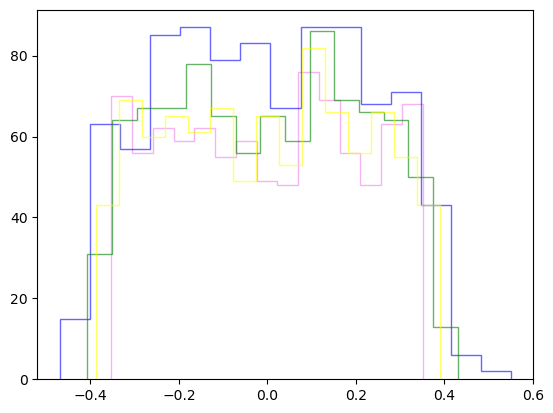

In [96]:
plt.figure()
color_vec = ["violet","blue","green","yellow","orange","red","pink"]
for i,lam_val in enumerate(a.models.keys()):
    plt.hist(weight_spurion[lam_val].detach().cpu().flatten(),color = color_vec[i],alpha = 0.6,bins = 15,histtype = "step")
plt.show()

now transformed_spurions = True
[tensor([0.0000, 0.0000, 0.4794, 0.8776], device='cuda:0')]
lam = 0.0, var = 1.5616e+01 MSE = 1.3452e-04, symm = 2.2589e+01 unbroken symm = 0.0005356886540539563


<Figure size 640x480 with 0 Axes>

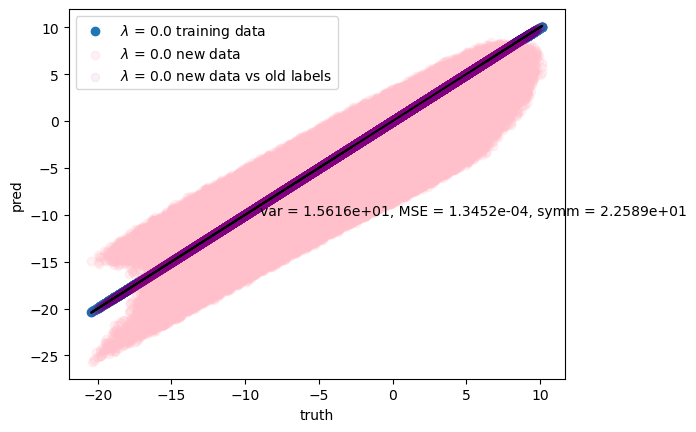

lam = 0.01, var = 4.3325e+00 MSE = 1.7050e-04, symm = 3.9983e-03 unbroken symm = 0.0005810213624499738


<Figure size 640x480 with 0 Axes>

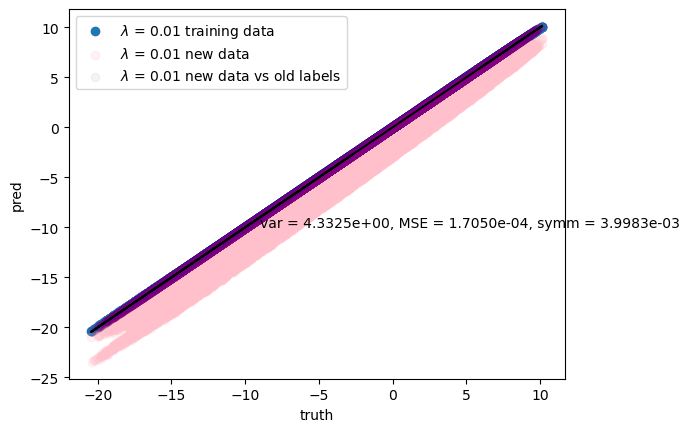

lam = 0.1, var = 2.5956e+00 MSE = 3.0159e-04, symm = 1.5034e-03 unbroken symm = 0.0004913769662380219


<Figure size 640x480 with 0 Axes>

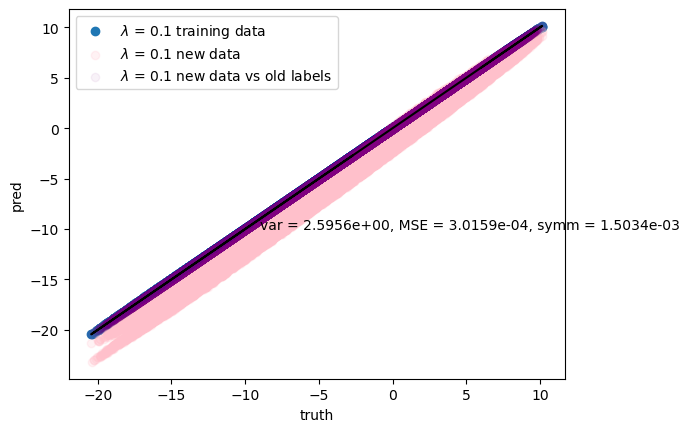

lam = 1.0, var = 1.5003e+00 MSE = 4.9126e-04, symm = 9.0137e-05 unbroken symm = 4.9830756324809045e-05


<Figure size 640x480 with 0 Axes>

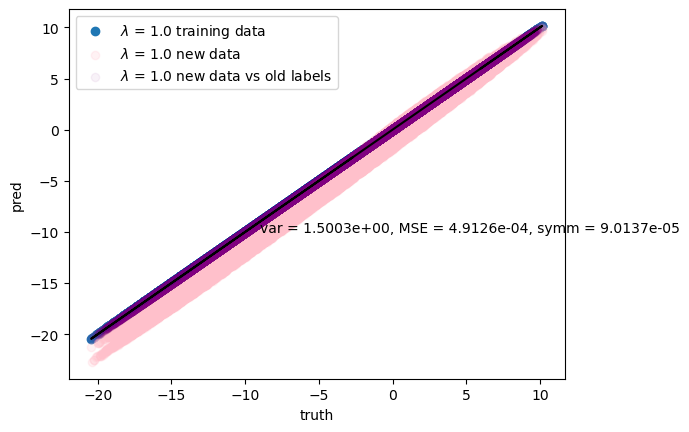

lam = 10.0, var = 1.0647e+00 MSE = 5.8318e-04, symm = 1.2483e-05 unbroken symm = 6.1273658502614126e-06


<Figure size 640x480 with 0 Axes>

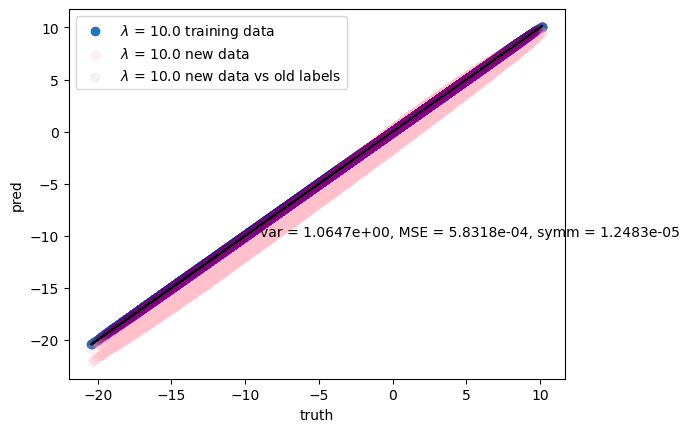

now transformed_spurions = True
[tensor([-2.0647,  0.0000,  0.0000,  2.2942], device='cuda:0')]
lam = 0.0, var = 2.4842e+03 MSE = 1.3452e-04, symm = 2.2589e+01 unbroken symm = 0.0005356886540539563


<Figure size 640x480 with 0 Axes>

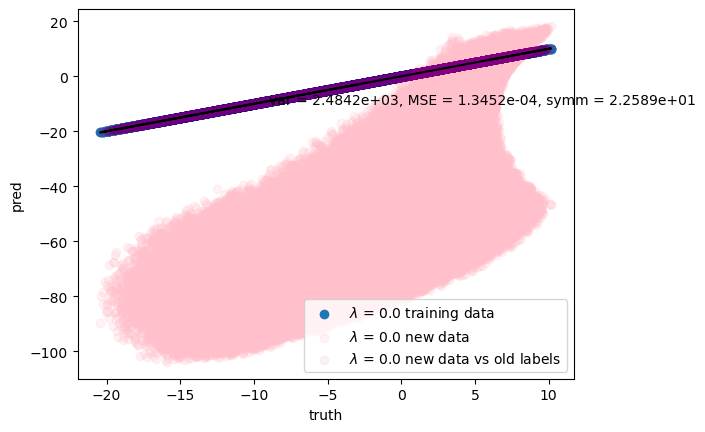

lam = 0.01, var = 1.2551e+03 MSE = 1.7050e-04, symm = 3.9983e-03 unbroken symm = 0.0005810213624499738


<Figure size 640x480 with 0 Axes>

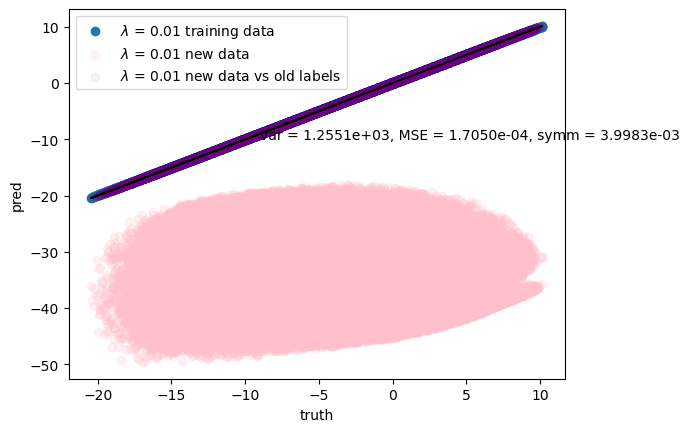

lam = 0.1, var = 1.4653e+03 MSE = 3.0159e-04, symm = 1.5034e-03 unbroken symm = 0.0004913769662380219


<Figure size 640x480 with 0 Axes>

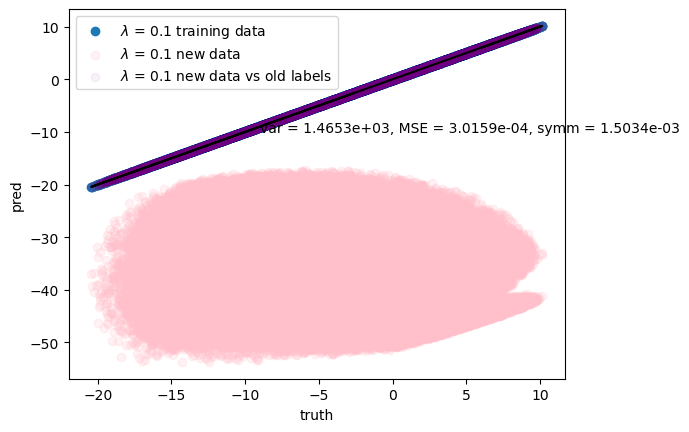

lam = 1.0, var = 2.1485e+03 MSE = 4.9126e-04, symm = 9.0137e-05 unbroken symm = 4.9830756324809045e-05


<Figure size 640x480 with 0 Axes>

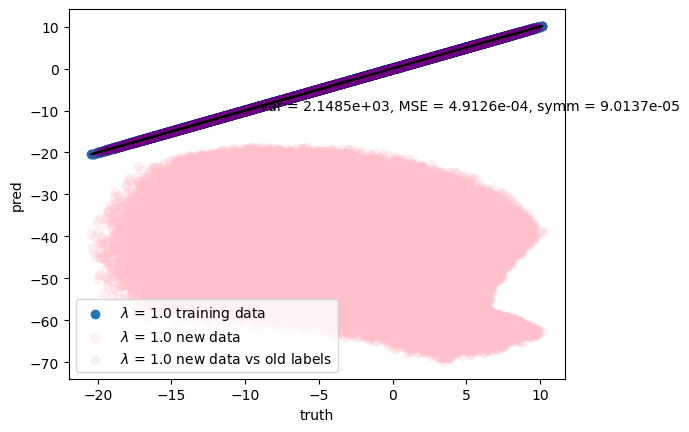

lam = 10.0, var = 2.3389e+03 MSE = 5.8318e-04, symm = 1.2483e-05 unbroken symm = 6.1273658502614126e-06


<Figure size 640x480 with 0 Axes>

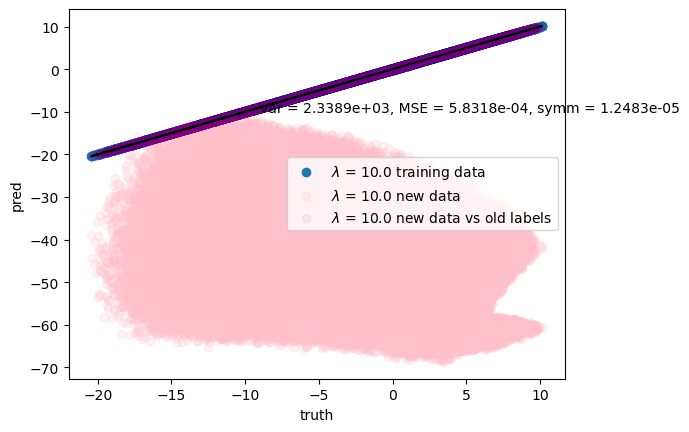

In [11]:
filename = "N_100000_hidden_size_300_layers_3_activation_GeLU_lr_1e-05_opt_Adam__broken_symm_input_spurionsdata_seed_3798_train_seed_1230"
a = analyze(filename, "last",theta_dir = torch.tensor([1,0,0]),theta = 0.5,beta = 0.9,beta_dir = torch.tensor([0,0,1]),transformed_spurions = "True")

<Figure size 640x480 with 0 Axes>

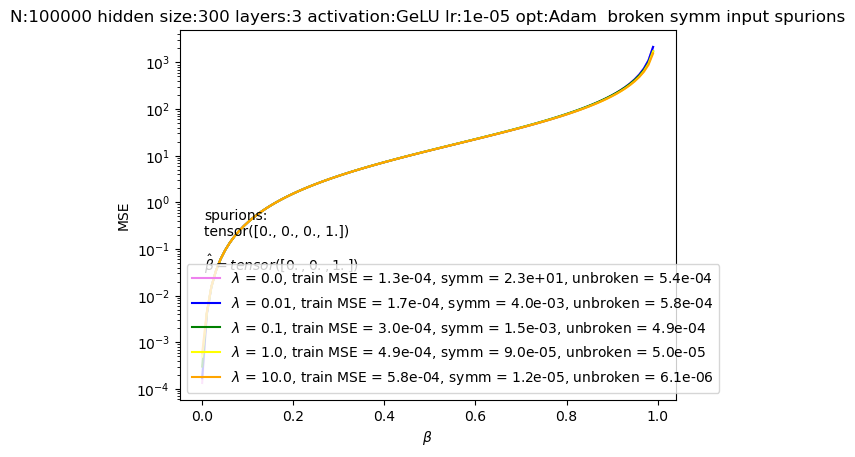

In [98]:
performance_plot_ext(a,save=True,filename="z",beta_dir = torch.tensor([0.0,0.0,1.0]),transformed_spurions = "False")

<Figure size 640x480 with 0 Axes>

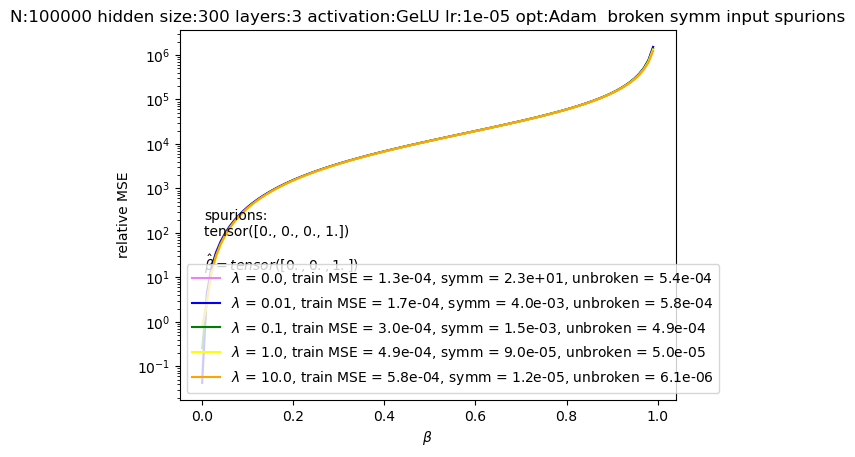

In [114]:
performance_plot_ext(a,save=True,filename="z_rel",beta_dir = torch.tensor([0.0,0.0,1.0]),transformed_spurions = "False",relative = True)

<Figure size 640x480 with 0 Axes>

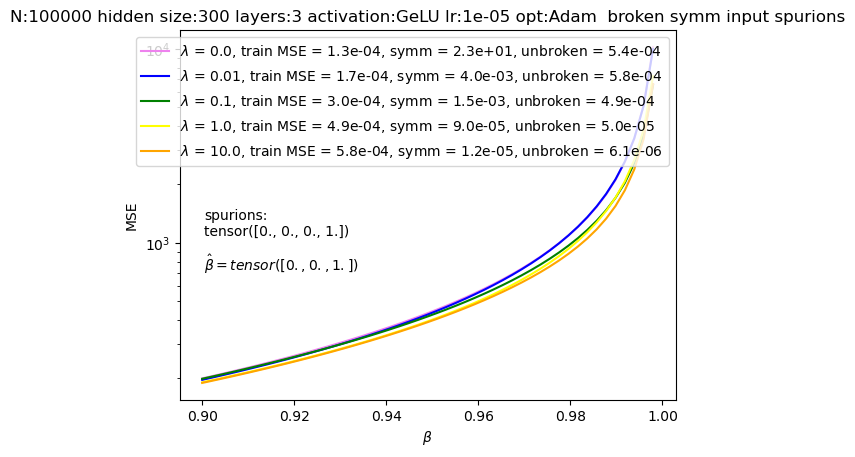

In [102]:
performance_plot_ext(a,beta_range = torch.linspace(0.9,1,50),save=False,filename="z",beta_dir = torch.tensor([0.0,0.0,1.0]),transformed_spurions = "False")

<Figure size 640x480 with 0 Axes>

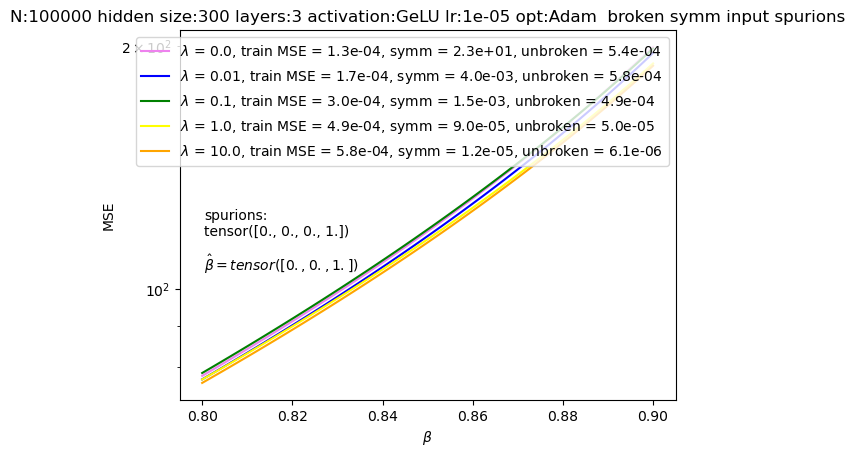

In [128]:
performance_plot_ext(a,beta_range = torch.linspace(0.8,0.9,50),save=False,filename="z_rel",beta_dir = torch.tensor([0.0,0.0,1.0]),transformed_spurions = "False",relative = False)

<Figure size 640x480 with 0 Axes>

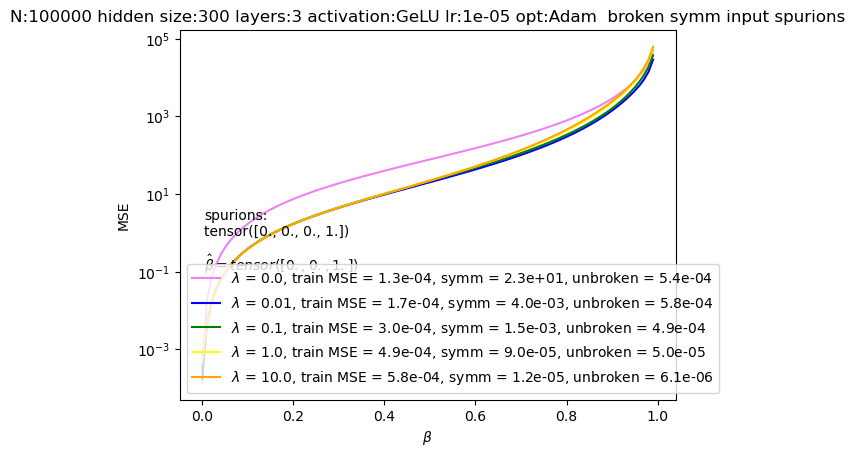

In [12]:
performance_plot_ext(a,save=True,filename="z",beta_dir = torch.tensor([0.0,0.0,1.0]),transformed_spurions = "True")

<Figure size 640x480 with 0 Axes>

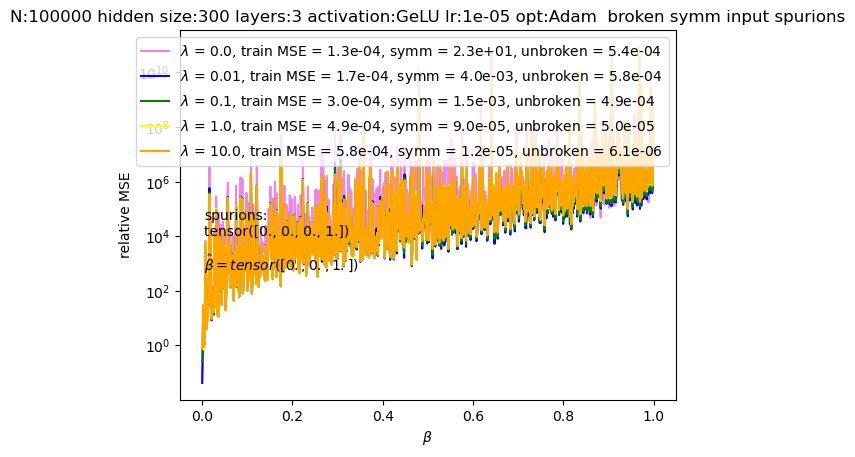

In [115]:
performance_plot_ext(a,save=True,filename="z_rel",beta_range = torch.linspace(0.0,1.0,1000),beta_dir = torch.tensor([0.0,0.0,1.0]),transformed_spurions = "True",relative = True)

<Figure size 640x480 with 0 Axes>

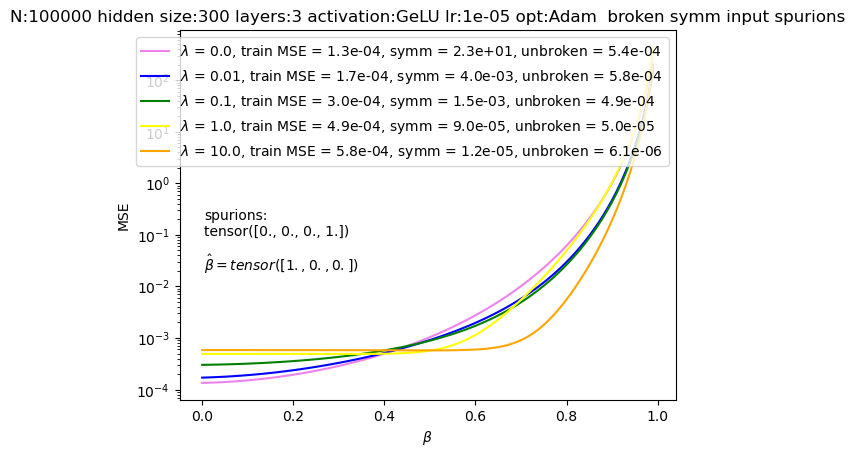

In [109]:
performance_plot_ext(a,save=True,filename="x",beta_dir = torch.tensor([1.0,0.0,0.0]))

<Figure size 640x480 with 0 Axes>

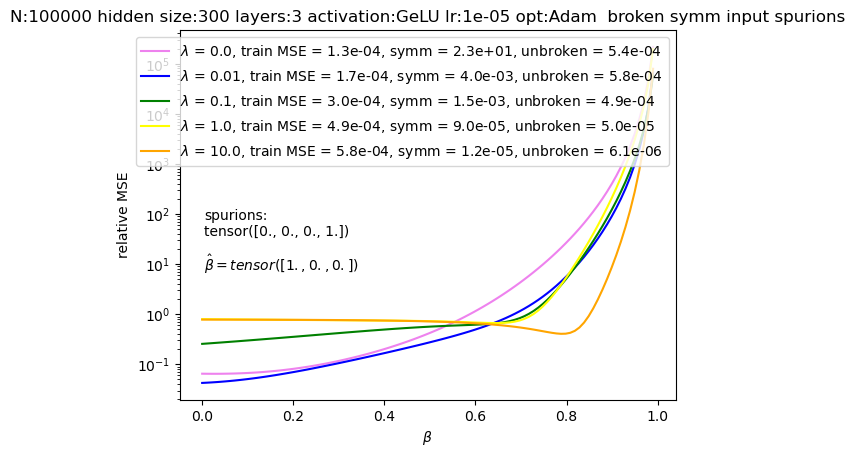

In [110]:
performance_plot_ext(a,save=True,filename="x_rel",beta_dir = torch.tensor([1.0,0.0,0.0]),relative = True)

<Figure size 640x480 with 0 Axes>

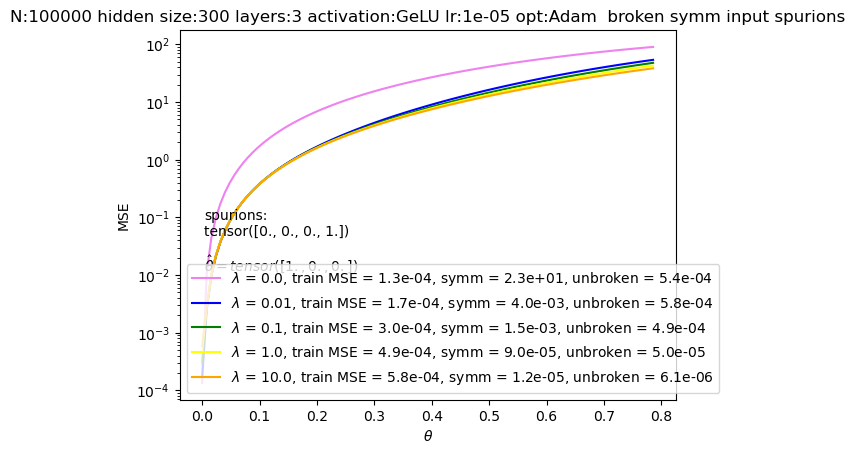

In [129]:
performance_plot_ext_theta(a,save=True,filename="x",theta_dir = torch.tensor([1.0,0.0,0.0]),theta_range = torch.linspace(0.0,np.pi/4,100))

<Figure size 640x480 with 0 Axes>

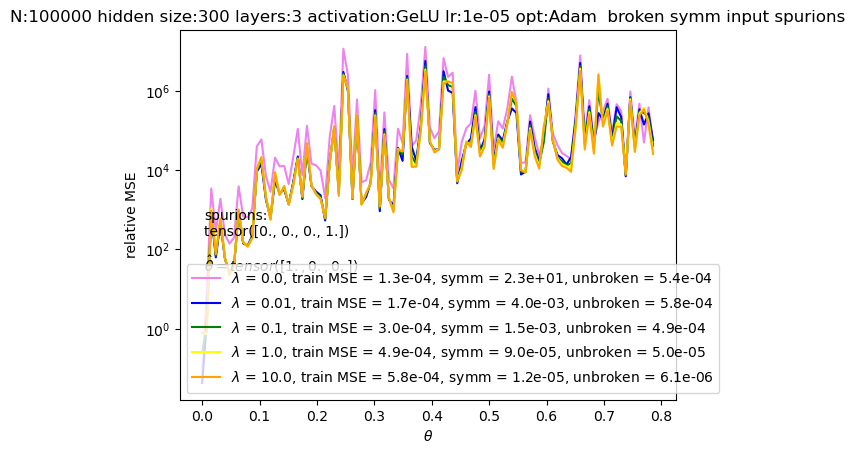

In [130]:
performance_plot_ext_theta(a,save=True,filename="x_rel",theta_dir = torch.tensor([1.0,0.0,0.0]),theta_range = torch.linspace(0.0,np.pi/4,100),relative = True)

<Figure size 640x480 with 0 Axes>

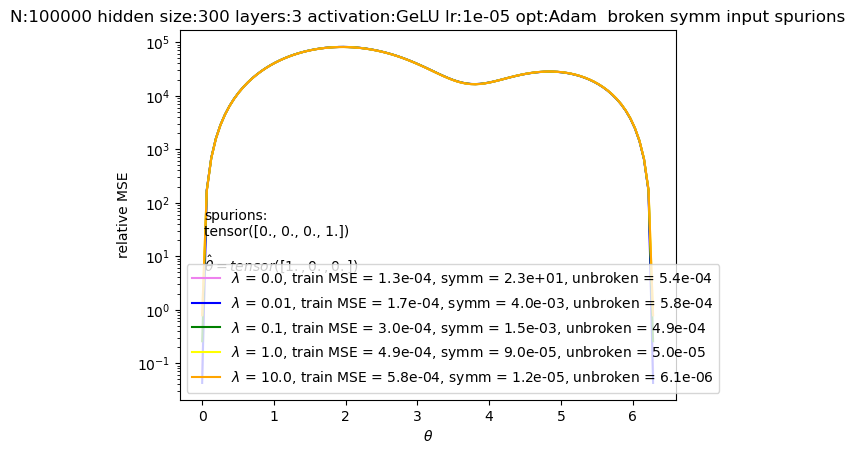

In [125]:
performance_plot_ext_theta(a,save=True,filename="x_rel",theta_dir = torch.tensor([1.0,0.0,0.0]),transformed_spurions="False",relative = True)

<Figure size 640x480 with 0 Axes>

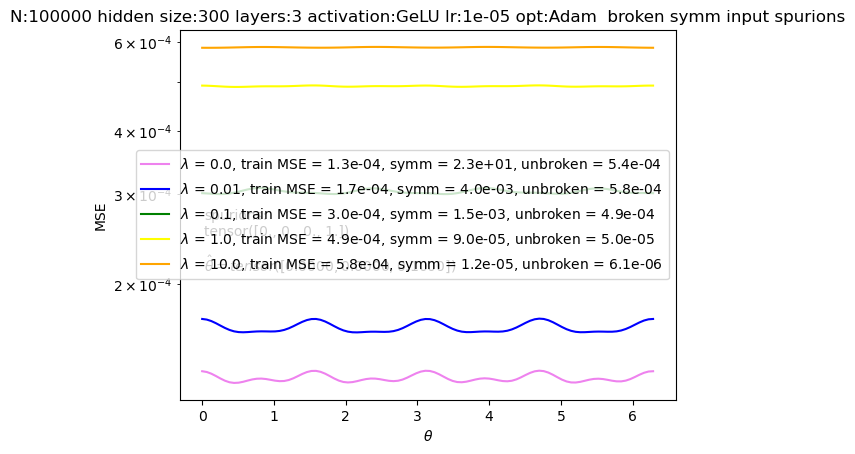

In [121]:
performance_plot_ext_theta(a,save=True,filename="z",theta_dir = torch.tensor([0.0,0.0,0.1]))